<center>
<a href="http://www.insa-toulouse.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/logo-insa.jpg" style="float:left; max-width: 120px; display: inline" alt="INSA"/></a> 
</center>

# [Projet machine learning](Projet-ML)

## Objectifs : 
<span style="color:  rgb(139, 0, 0)">**Notre projet consiste à analyser et faire des prédictions sur un jeu de données qui fournit un aperçu détaillé des routines d’exercice, des attributs physiques et des mesures de la condition physique des membres d’une salle de sport. Il y a deux objectifs principales pour ce projet :  Le premier objectif est de faire une analyse exploratoire des données pour bien cerner nos données. Dans un second temps, on effectuera deux modélisations avec la prédiction de calories brulées et du niveau d'expérience.**</span>

## Table des matières
1. [Analyse explorative des données (langage R)](#analyse-données)
   - Description général (natures des variables, encodages ...)
   - Analyse descriptive unidimensionnelle et bidimensionnelle
   - ACP des différentes variables
2. [Modélisation (langage R et python)](#modélisation)
   - Prédiction des calories brulées (régression)
   - Prédiction du niveau d'expérience (classification)
# 1. Analyse explorative des donées (langage R)
Cette partie se fera uniquement en R, l'analyse est dans l'autre notebook.

# 2. Modélisation (langage python)

# 2.1 Prédiction des calories brulées (régression)

README : ce qu'il reste à faire 

    -Sélections de variables et comparer sans (quasi fini)

    -Comparer en fonction du MSE, du R^2 score, des résidus et les courbes prédit/vrai (en cours)
    
    -Eventuellement optimiser quelques méthodes (arbres, réseaux ) attention long : faire sur le serveur GMM (peut-être des détails encore )

    -Interprétation  : 
Moins de variables → modèle plus simple → moins de variance captée
→ d’où un R² plus faible (moins de variance expliquée au total).

Mais moins de bruit aussi → prédictions plus robustes
→ d’où un MSE plus faible, car les erreurs absolues sont réduites (moins de sur-apprentissage).

Le modèle avec toutes les variables (sans sélection) :

Explique mieux la variance totale des données (R² ↑)

Mais surestime / surapprend certains points, ce qui augmente l’erreur moyenne (MSE ↑)

    -Faire un boosting

## 2.1.1 Ajustement des données 

Avant tout, on va importer nos données et appliquer les modifications faites durant la première partie explorative en R en python. 

In [30]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
data=pd.read_csv("gym_members_exercise_tracking.csv",sep=",",header=0)
data.head()
data.dtypes
#On doit vérifier si les types sont bon, par exemple on va interpréter Experience_Level et Workout_Frequency comme des variables qualitatives avec des modalités. 

Age                                int64
Gender                            object
Weight (kg)                      float64
Height (m)                       float64
Max_BPM                            int64
Avg_BPM                            int64
Resting_BPM                        int64
Session_Duration (hours)         float64
Calories_Burned                  float64
Workout_Type                      object
Fat_Percentage                   float64
Water_Intake (liters)            float64
Workout_Frequency (days/week)      int64
Experience_Level                   int64
BMI                              float64
dtype: object

On va transformer nos données qualitatives en catégories pour pouvoir les transformées en données numériques exploitables grâce à la fonction *get_dummies* de *panda* . 

In [31]:
#Transformation de nos données au bon format voulu
data["Gender"]=pd.Categorical(data["Gender"],ordered=False)
data["Workout_Type"]=pd.Categorical(data["Workout_Type"],ordered=False)
data["Workout_Frequency (days/week)"]=pd.Categorical(data["Workout_Frequency (days/week)"],ordered=False)
data["Experience_Level"]=pd.Categorical(data["Experience_Level"],ordered=False)
data.dtypes

Age                                 int64
Gender                           category
Weight (kg)                       float64
Height (m)                        float64
Max_BPM                             int64
Avg_BPM                             int64
Resting_BPM                         int64
Session_Duration (hours)          float64
Calories_Burned                   float64
Workout_Type                     category
Fat_Percentage                    float64
Water_Intake (liters)             float64
Workout_Frequency (days/week)    category
Experience_Level                 category
BMI                               float64
dtype: object

In [32]:
data.describe()

,Age,Weight (kg),Height (m),Max_BPM,Avg_BPM,Resting_BPM,Session_Duration (hours),Calories_Burned,Fat_Percentage,Water_Intake (liters),BMI
count,973.000000,973.000000,973.00000,973.000000,973.000000,973.000000,973.000000,973.000000,973.000000,973.000000,973.000000
mean,38.683453,73.854676,1.72258,179.883864,143.766701,62.223022,1.256423,905.422405,24.976773,2.626619,24.912127
std,12.180928,21.207500,0.12772,11.525686,14.345101,7.327060,0.343033,272.641516,6.259419,0.600172,6.660879
min,18.000000,40.000000,1.50000,160.000000,120.000000,50.000000,0.500000,303.000000,10.000000,1.500000,12.320000
25%,28.000000,58.100000,1.62000,170.000000,131.000000,56.000000,1.040000,720.000000,21.300000,2.200000,20.110000
50%,40.000000,70.000000,1.71000,180.000000,143.000000,62.000000,1.260000,893.000000,26.200000,2.600000,24.160000
75%,49.000000,86.000000,1.80000,190.000000,156.000000,68.000000,1.460000,1076.000000,29.300000,3.100000,28.560000
max,59.000000,129.900000,2.00000,199.000000,169.000000,74.000000,2.000000,1783.000000,35.000000,3.700000,49.840000


On va maintenant récupérer les variables explicatives en transformant les données de manière a pouvoir les utiliser en régression et classification. 

In [33]:
#Variables explicatives
################Variables qualitatives
dataDum=pd.get_dummies(data[["Gender","Workout_Type","Workout_Frequency (days/week)","Experience_Level"]]) 
# pour transformer des variables qualitatives en variables indicatrices, 
# chaque valeur unique de la variable qualitative devient une colonne distincte dans le DataFrame résultant

################Variables quantitatives
dataQuant=data[["Age","Weight (kg)","Height (m)","Max_BPM","Avg_BPM","Resting_BPM","Session_Duration (hours)","Fat_Percentage","Water_Intake (liters)","BMI"]] 

# Concaténation des variables explicatives
dfC=pd.concat([dataDum,dataQuant],axis=1)
dfC.head()
#print(type(dfC))
dfC.dtypes

Gender_Female                         bool
Gender_Male                           bool
Workout_Type_Cardio                   bool
Workout_Type_HIIT                     bool
Workout_Type_Strength                 bool
Workout_Type_Yoga                     bool
Workout_Frequency (days/week)_2       bool
Workout_Frequency (days/week)_3       bool
Workout_Frequency (days/week)_4       bool
Workout_Frequency (days/week)_5       bool
Experience_Level_1                    bool
Experience_Level_2                    bool
Experience_Level_3                    bool
Age                                  int64
Weight (kg)                        float64
Height (m)                         float64
Max_BPM                              int64
Avg_BPM                              int64
Resting_BPM                          int64
Session_Duration (hours)           float64
Fat_Percentage                     float64
Water_Intake (liters)              float64
BMI                                float64
dtype: obje

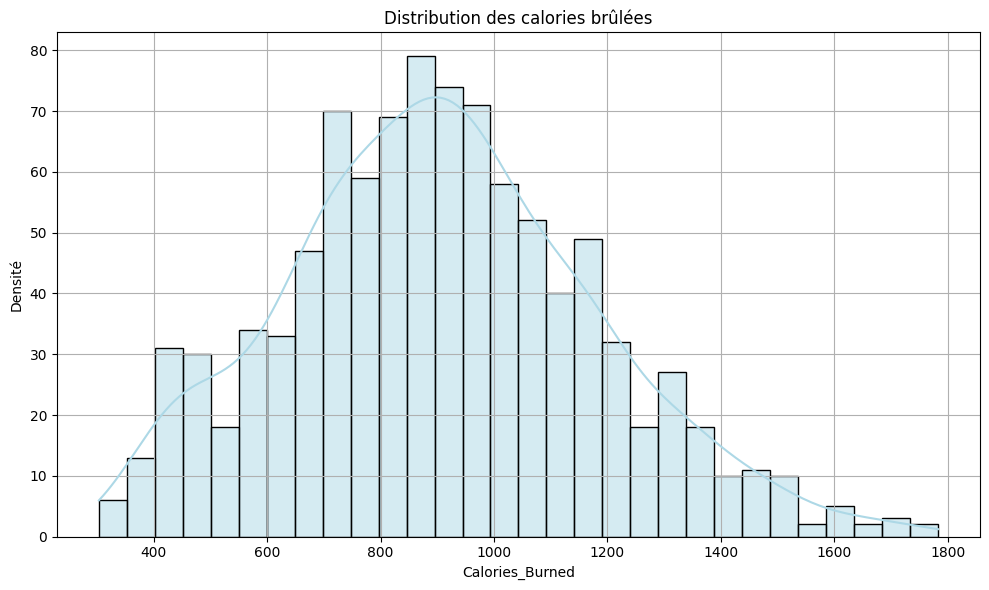

In [34]:
import seaborn as sns
#Variables à prédire/expliquer 
YC=data["Calories_Burned"]
#print(type(YC))
# Paramètres personnalisables
bw = 50  # Largeur des bins (modifiable)
title = "Distribution des calories brûlées"

# Tracé
plt.figure(figsize=(10, 6))
sns.histplot(YC, kde=True, binwidth=bw, color="lightblue", edgecolor="black")
plt.title(title)
plt.xlabel("Calories_Burned")
plt.ylabel("Densité")
plt.grid(True)
plt.tight_layout()
plt.show()

On va tracer des histogrammes de nos variables continues pour appliquées des transformations si besoin. 

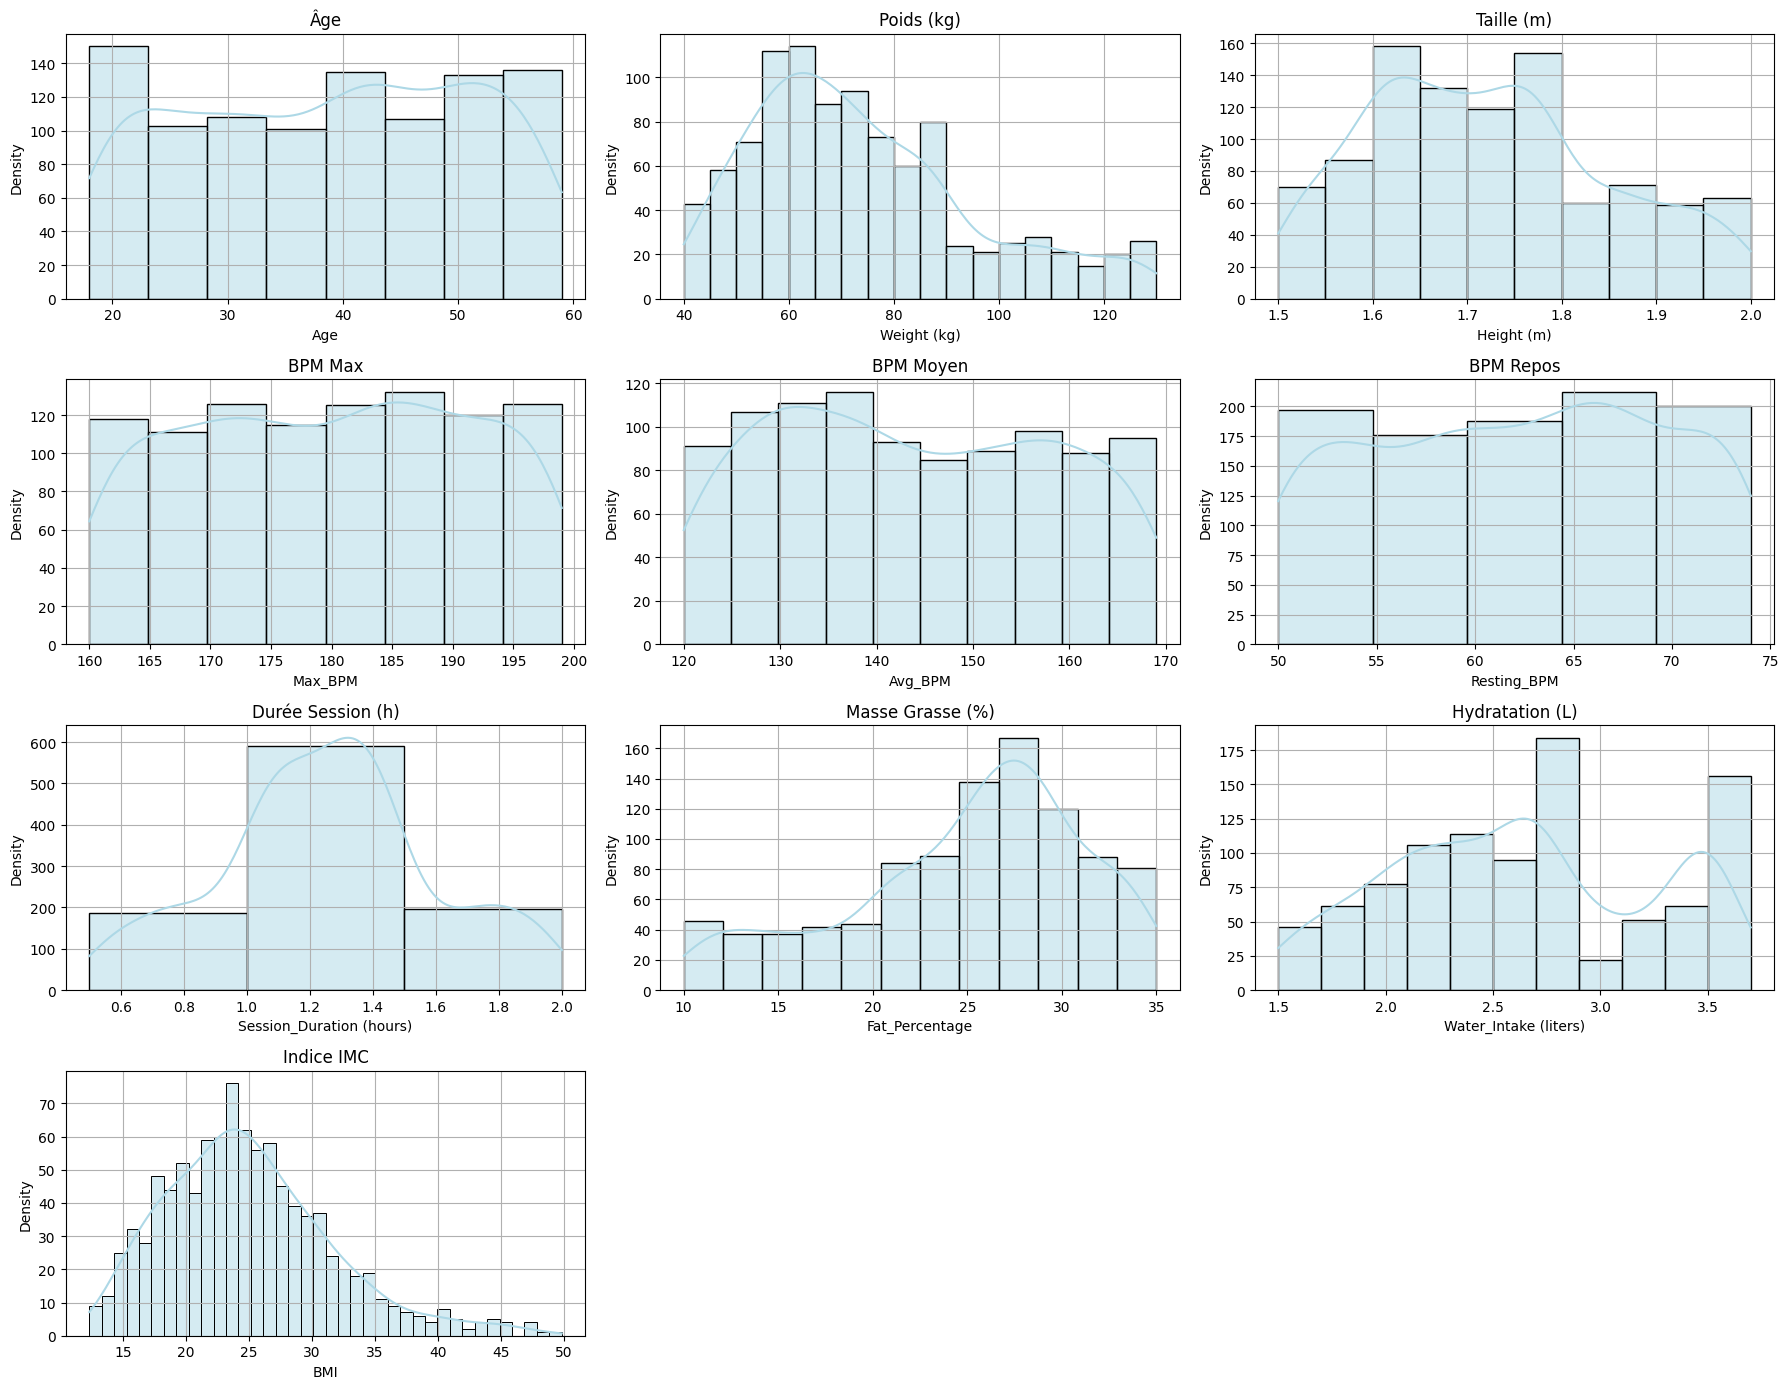

In [ ]:

# on trace les histogrammes des variables continues non transformées
# pour détecter les asymétries, valeurs extrêmes etc

plots = [
    ('Age', "Âge", 5),
    ('Weight (kg)', "Poids (kg)", 5),
    ('Height (m)', "Taille (m)", 0.05),
    ('Max_BPM', "BPM Max", 5),
    ('Avg_BPM', "BPM Moyen", 5),
    ('Resting_BPM', "BPM Repos", 5),
    ('Session_Duration (hours)', "Durée Session (h)", 0.5),
    ('Fat_Percentage', "Masse Grasse (%)", 2),
    ('Water_Intake (liters)', "Hydratation (L)", 0.2),
    ('BMI', "Indice IMC", 1),
]
fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(18, 14))
axs = axs.flatten()

for ax, (col, title, bw) in zip(axs, plots):
    sns.histplot(dfC[col], kde=True, binwidth=bw, ax=ax, color="lightblue", edgecolor="black")
    ax.set_title(title)
    ax.set_xlabel(col)
    ax.set_ylabel("Density")
    ax.grid(True)

for ax in axs[len(plots):]:
    ax.axis("off")

plt.tight_layout()
plt.show()


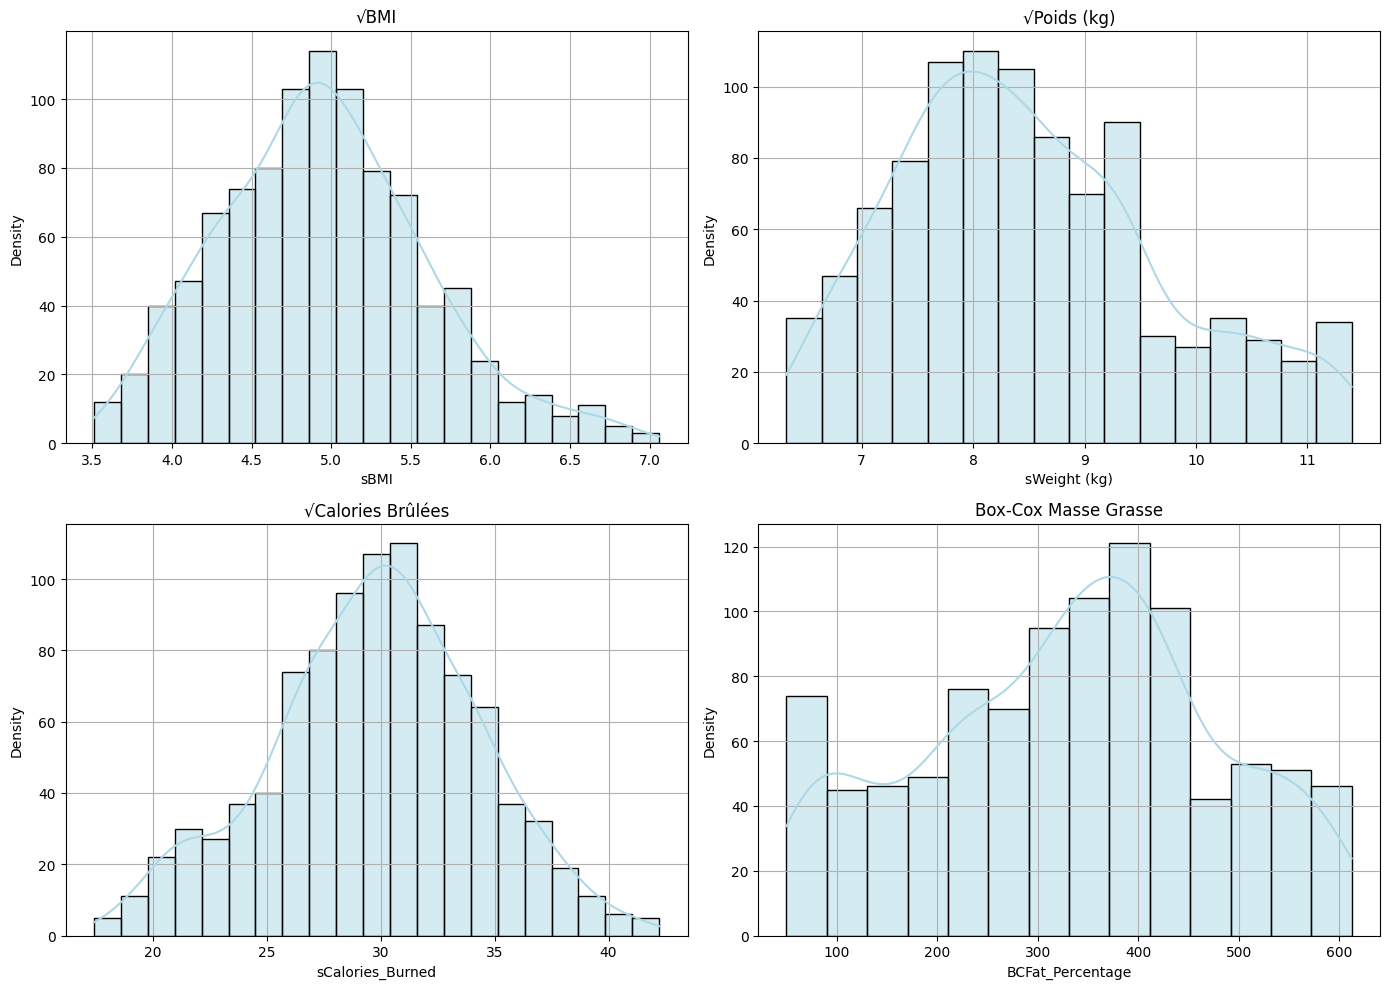

In [36]:
#transformation des variables continues
# on corrige l'asymétrie de certaines variables via racine carrée
# et transformation de type box-cox

df_norm = dfC.copy()
YC_norm=YC.copy()
df_norm['sBMI'] = np.sqrt(df_norm['BMI'])
df_norm['sWeight (kg)'] = np.sqrt(df_norm['Weight (kg)'])

lambda_ = 2
df_norm['BCFat_Percentage'] = (df_norm['Fat_Percentage'] ** lambda_) / lambda_
YC_norm=np.sqrt(YC)
# visualisation des distributions transformées
plots = [
    ('sBMI', '√BMI'),
    ('sWeight (kg)', '√Poids (kg)'),
    ('sCalories_Burned', '√Calories Brûlées'),
    ('BCFat_Percentage', 'Box-Cox Masse Grasse')
]
#Juste pour le plot 
Plot=df_norm.copy()

Plot["sCalories_Burned"]=YC_norm
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))
axs = axs.flatten()

for ax, (col, title) in zip(axs, plots):
    sns.histplot(Plot[col], kde=True, ax=ax, color="lightblue", edgecolor="black")
    ax.set_title(title)
    ax.set_xlabel(col)
    ax.set_ylabel("Density")
    ax.grid(True)

plt.tight_layout()
plt.show()

On va maintenant séparer nos données en deux échantillons : échantillon d'entrainement et un échantillon test. 

In [37]:
from sklearn.model_selection import train_test_split  
Lignes_Data=data.shape[0]
Colonnes_Data=data.shape[1]
Nbre_Element=data.size
#Séparation de notre jeu de données en 4 sous ensembles en 2 parties : parti test, parti train
Xc_train,Xc_test,YC_train,YC_test=train_test_split(df_norm,YC,test_size=0.2,random_state=11) #test_size=0.2 indique qu'on prend 20%
#print(type(YC_train))

On va standardiser nos données, indispensables pour une utilisation efficase des algorithmes non linéaires : SVM, réseaux de neuronnes etc ...

In [38]:
from sklearn.preprocessing import StandardScaler 
scaler = StandardScaler()  
scaler.fit(Xc_train)  
XC_train = scaler.transform(Xc_train)  
# Meme transformation sur le test
XC_test = scaler.transform(Xc_test)

## Procédures de comparaison : 
Afin de comparer les différentes méthodes de comparaisons, on va calculer les  métriques habituels :  
| **Métrique** | **Sensibilité aux outliers** | **Interprétation directe** | **Utilité principale**  |
| ------------ | ---------------------------- | -------------------------- | ----------------------- |
| MSE          | Forte                        | Non                        | Comparaison fine        |
| RMSE         | Forte                        | Oui                        | Compréhension intuitive |
| MAE          | Faible                       | Oui                        | Robustesse              |
| R²           | Moyenne                      | Oui                        | Variance expliquée      |
| R² ajusté    | Moyenne                      | Oui                        | Comparaison de modèles  |

On va aussi tracer les valeurs prédites/valeurs observées ainsi que les résidus pour chaque modèle. Pour les modèles possédant des hyperparamètres à optimiser, on va procéder par validation en utilisant *GridSearchCV* dans *sklear*. Une fois la meilleur configuration de paramètres trouver, on stockera ce modèle et tout à la fin on va effectuer une comparaison sur données test (ou validation croisée) : 

Fonction *cross_val_score()* 

    -  X : données | y : variable à expliquer | model : modèle à évaluer | cv : nombre de plis. 

    -  Pour i = 1... cv : 

        Divise X,y en cv plis  : 1 plis de validation et les autres pour l'entrainement

        Le modèle est entrainement et tester sur ces plis, on stok le MSE associé

    - Renvoie un tableau avec les cv MSE associé et l'écart-type. 
        


## Bilan procédure général : 
 ### 1. Optimisation des éventuelles hyperparamètres :
 -  Trouver le(s) meilleur(s) hyperparamètre(s) $\alpha*$.

 -  Obtenir le modèle entraîné avec ce(s) $\alpha*$.
 ### 2. Validation croisée finale "extérieure" (sur ce modèle figé avec alpha*) : :

 - Appliquer *cross_val_score()* avec ce modèle et ce(s) $\alpha*$ figé.

 -  Obtenir une estimation non biaisée de ses performances.

In [39]:
####Dictionnaires des MSE et R² pour comparaison
mse_score_model={}
R2_model={}

mse_score_model_sel={}
R2_model_sel={}

## 2.2 Régression par modèles linéaires 

Cette première partie concerne les modèles linéaires de régression standards, avec ou sans pénalisation. On applique en premier lieu une régression sans pénalisation puis avec une pénalisation Lasso. 

La pénalisation Lasso va nous permettre de faire de la sélection de variables et on va pouvoir observer l'impact d'une sélection de variable sur nos prédictions. 


## Modèle linéaire sans pénalisation

In [40]:
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
# Création du modèle linéaire sans régularisation
regLin = LinearRegression()

# Entraînement sur les données d'entraînement
regLin.fit(XC_train, YC_train)

# Prédictions sur l’échantillon test
prev_lin = regLin.predict(XC_test)

# Évaluation
mse_lin = mean_squared_error(YC_test, prev_lin)
r2_lin = r2_score(YC_test, prev_lin)

print("MSE =", mse_lin)
print("R² =", r2_lin)

mse_score_model["Linear Regression"]=mse_lin
R2_model["Linear Regression"]=r2_lin


MSE = 1433.8426130342832
R² = 0.9831584658621288


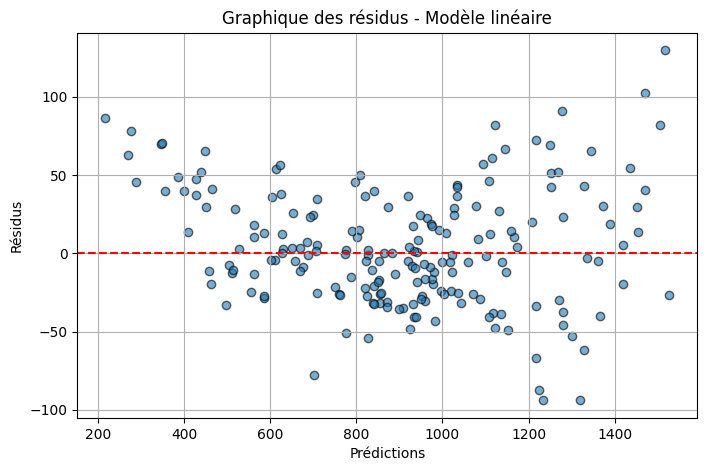

In [41]:
residus=YC_test-prev_lin
plt.figure(figsize=(8,5))
plt.scatter(prev_lin, residus, alpha=0.6, edgecolors='k')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Prédictions')
plt.ylabel('Résidus')
plt.title('Graphique des résidus - Modèle linéaire')
plt.grid(True)
plt.show()

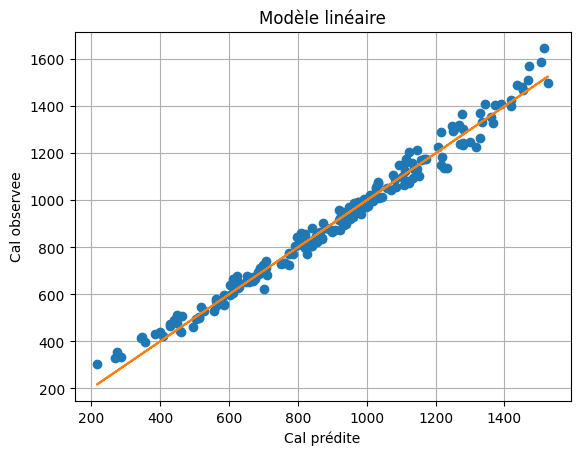

In [42]:
#Valeurs prédites contre les valeurs observées 
plt.plot(prev_lin,YC_test,"o")
plt.plot(prev_lin,prev_lin)
plt.xlabel(u"Cal prédite")
plt.ylabel("Cal observee")
plt.title("Modèle linéaire")
plt.grid(True)
plt.show()

## Pénalisation Lasso

On va maintenant appliquer une pénalisation Lasso avec optimisation de l'hyperparamètre par validation croisée. On va aussi utiliser cette pénalisation pour faire de la sélection de variables. 

In [43]:
from sklearn.model_selection import GridSearchCV

# grille de valeurs du paramètre alpha à optimiser
param=[{"alpha":[0.4,0.5,1.,1.2,1.3,1.4,1.5]}]
regLasso = GridSearchCV(linear_model.Lasso(), param,cv=5,n_jobs=-1)
regLassOpt=regLasso.fit(XC_train, YC_train)
# paramètre optimal
regLassOpt.best_params_["alpha"]
print("Meilleur R2 = %f, Meilleur paramètre = %s" % (regLassOpt.best_score_,regLassOpt.best_params_))
prev_Lasso_opt=regLassOpt.predict(XC_test)
print("Meilleur MSE=",mean_squared_error(prev_Lasso_opt,YC_test))
##  Meilleur R2 = 0.977484, Meilleur paramètre = {'alpha': 1.3}

Meilleur R2 = 0.977503, Meilleur paramètre = {'alpha': 1.3}
Meilleur MSE= 1586.5505980228327


In [44]:
#On stock dans nos dictionnaires
mse_score_model["Lasso"]=mean_squared_error(YC_test,prev_Lasso_opt)
R2_model["Lasso"]=r2_score(YC_test,prev_Lasso_opt)

# Coefficients
regLassoOpt=linear_model.Lasso(alpha=regLassOpt.best_params_['alpha'])
model_lasso_Opt=regLassoOpt.fit(XC_train,YC_train)
print("Matric des coefficients=",model_lasso_Opt.coef_) #matrice des coefficients

coef = pd.Series(model_lasso_Opt.coef_, index = Xc_train.columns)
print("Lasso conserve " + str(sum(coef != 0)) + 
      " variables et en supprime " +  str(sum(coef == 0)))


Matric des coefficients= [-4.09088889e+01  2.41401871e-13  2.24628604e-01 -0.00000000e+00
  0.00000000e+00 -2.16511389e+00 -0.00000000e+00 -0.00000000e+00
  0.00000000e+00  4.94375900e-01 -1.27933668e-01  0.00000000e+00
  0.00000000e+00 -4.00221686e+01  0.00000000e+00  5.27409574e-01
 -0.00000000e+00  8.88551380e+01  6.89504935e-01  2.40691320e+02
 -8.38169449e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.45089225e+00 -0.00000000e+00]
Lasso conserve 13 variables et en supprime 13


In [45]:
# Variables retenues (coefficients non nuls)
coeff=model_lasso_Opt.coef_
retained_vars = [(var, coef) for var, coef in zip(dfC.columns, coeff) if coef != 0]

print("\nVariables retenues par Lasso (coefficients non nuls) :n=",len(retained_vars))
for var, coef in retained_vars:
    print(f"{var:30s} -> {coef:.4f}")


Variables retenues par Lasso (coefficients non nuls) :n= 12
Gender_Female                  -> -40.9089
Gender_Male                    -> 0.0000
Workout_Type_Cardio            -> 0.2246
Workout_Type_Yoga              -> -2.1651
Workout_Frequency (days/week)_5 -> 0.4944
Experience_Level_1             -> -0.1279
Age                            -> -40.0222
Height (m)                     -> 0.5274
Avg_BPM                        -> 88.8551
Resting_BPM                    -> 0.6895
Session_Duration (hours)       -> 240.6913
Fat_Percentage                 -> -0.8382


Text(0.5, 1.0, 'Coefficients du modèle lasso')

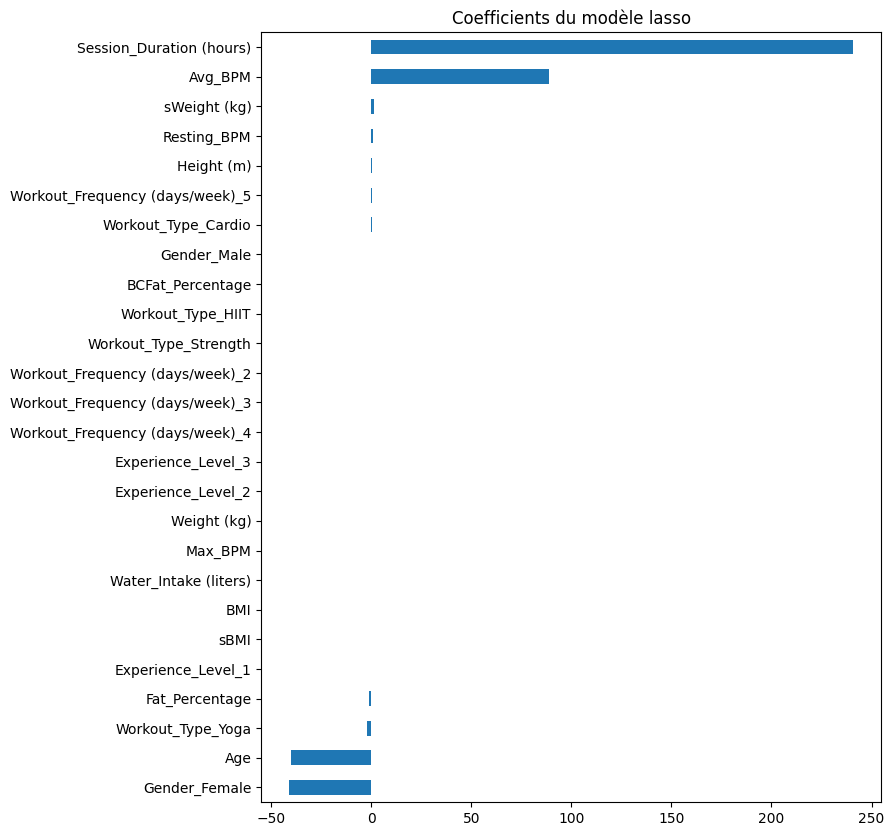

In [46]:
coef = pd.Series(coeff, index = Xc_train.columns)
imp_coef = coef.sort_values()
plt.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title(u"Coefficients du modèle lasso")

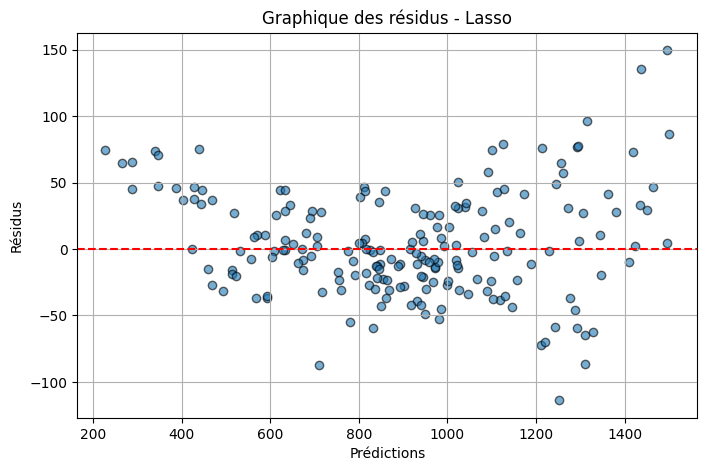

In [47]:
#print(type(YC_test))*
prev_Lasso_opt=regLassOpt.predict(XC_test)
residus=YC_test-prev_Lasso_opt
plt.figure(figsize=(8,5))
plt.scatter(prev_Lasso_opt, residus, alpha=0.6, edgecolors='k')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Prédictions')
plt.ylabel('Résidus')
plt.title('Graphique des résidus - Lasso')
plt.grid(True)
plt.show()

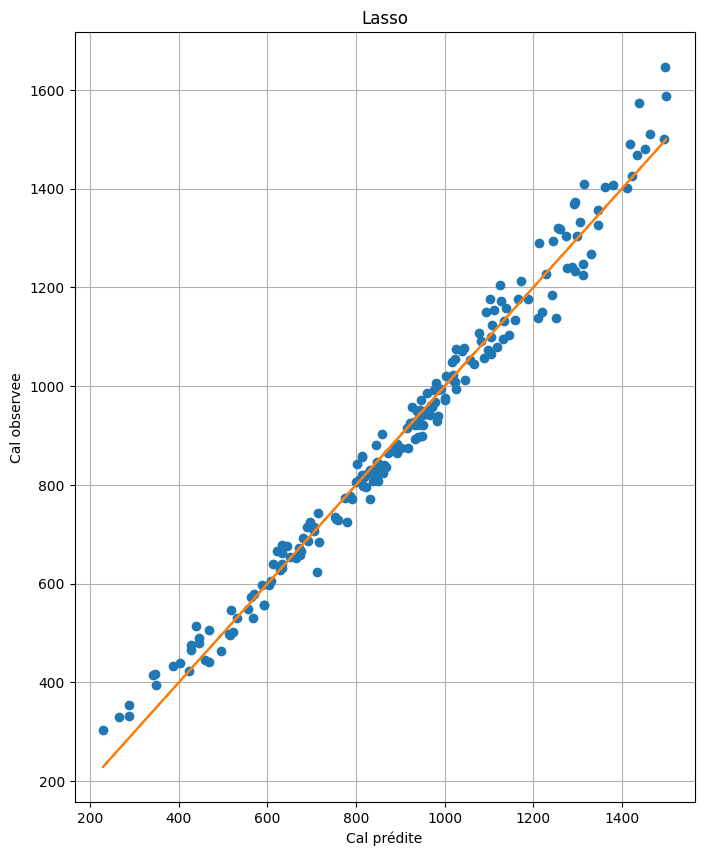

In [48]:
#Valeurs prédites contre les valeurs observées 
plt.plot(prev_Lasso_opt,YC_test,"o")
plt.plot(prev_Lasso_opt,prev_Lasso_opt)
plt.xlabel(u"Cal prédite")
plt.ylabel("Cal observee")
plt.title("Lasso")
plt.grid(True)
plt.show()

Matrice de confusion avec seuillage

In [49]:
from sklearn.metrics import confusion_matrix

prev_continuous=np.copy(prev_Lasso_opt)
YC_test_continuous=np.copy(YC_test)
##On prédit sur un seuil donné 
seuil = 500 #500 cal brulée 
table=confusion_matrix((prev_continuous > seuil).astype(int),(YC_test_continuous > seuil).astype(int))
print(table)

[[ 17   2]
 [  2 174]]


*Scikit-learn* propose d'autres procédures d'optimisation du paramètre de régularisation lasso par validation croisée en régression; `lassoCV` utilise un algorithme de *coordinate descent*, sans calcul de dérivée puisque la norme *l1* n'est pas dérivable, tandis que `lassoLarsCV` est basée sur l'algorithme de *least angle regression*. Ces fonctions permettent de tracer également les *chemins de régularisation*. Voici l'exemple de `lassoCV` qui offre plus d'options.

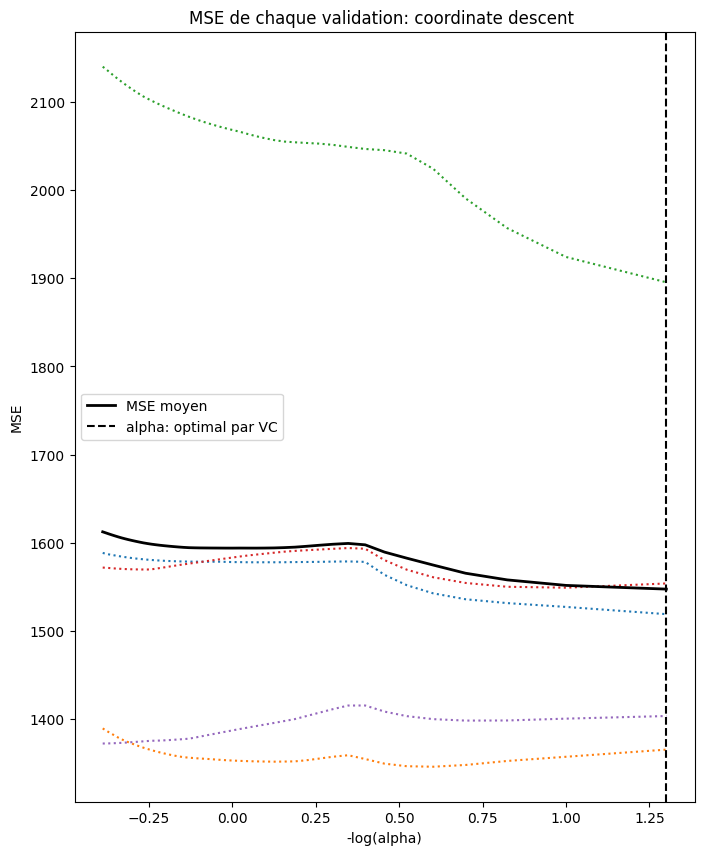

In [50]:
from sklearn.linear_model import LassoCV, LassoLarsCV
model = LassoCV(cv=5, alphas=np.array(range(1,50,1))/20.,n_jobs=-1,random_state=13).fit(XC_train,YC_train)
m_log_alphas = -np.log10(model.alphas_)

plt.figure()
# ymin, ymax = 2300, 3800
plt.plot(m_log_alphas, model.mse_path_, ':')
plt.plot(m_log_alphas, model.mse_path_.mean(axis=-1), 'k',
         label='MSE moyen', linewidth=2)
plt.axvline(-np.log10(model.alpha_), linestyle='--', color='k',
            label='alpha: optimal par VC')

plt.legend()
plt.xlabel('-log(alpha)')
plt.ylabel('MSE')
plt.title('MSE de chaque validation: coordinate descent ')
plt.show()

#Algo LassoLarCV --> pas de grands changements 


On retrouve le $-log(\alpha)=0.13$ environ soit environ $\alpha =1.3 $ (log en base décimale). On prend maintenant cette valeur pour $\alpha$ et on va faire de la sélection de variables. 

In [51]:
# Pour tout le jeu de données
from sklearn.linear_model import Lasso
alpha_opt=1.3
lasso = Lasso(alpha=1.3)
lasso.fit(XC_train, YC_train)

# Récupère les noms des variables retenues (coefficients ≠ 0)
coef = lasso.coef_
selected_features = [name for name, c in zip(dfC.columns, coef) if c != 0]

print("Variables retenues :", selected_features)
dfC_selected = dfC[selected_features]

#On renormalise nos données 
scaler = StandardScaler()
X_selected = dfC[selected_features]
X_train_sel, X_test_sel = train_test_split(X_selected, test_size=0.2, random_state=11)
XC_train_sel = scaler.fit_transform(X_train_sel)
XC_test_sel = scaler.transform(X_test_sel)


Variables retenues : ['Gender_Female', 'Gender_Male', 'Workout_Type_Cardio', 'Workout_Type_Yoga', 'Workout_Frequency (days/week)_5', 'Experience_Level_1', 'Age', 'Height (m)', 'Avg_BPM', 'Resting_BPM', 'Session_Duration (hours)', 'Fat_Percentage']


In [52]:
regLassOpt_sel=regLasso.fit(XC_train_sel, YC_train)
# paramètre optimal
regLassOpt_sel.best_params_["alpha"]
print("Meilleur R2 = %f (par validation croisée), Meilleur paramètre = %s" % (regLassOpt.best_score_,regLassOpt.best_params_))
prev_lasso_opt_sel=regLassOpt_sel.predict(XC_test_sel)
print("MSE=",mean_squared_error(prev_lasso_opt_sel,YC_test))
print("R2=",r2_score(YC_test,prev_lasso_opt_sel))   

mse_score_model_sel["Lasso"]=mean_squared_error(prev_lasso_opt_sel,YC_test)
R2_model_sel["Lasso"]=r2_score(YC_test,prev_lasso_opt_sel)

Meilleur R2 = 0.977580 (par validation croisée), Meilleur paramètre = {'alpha': 0.5}
MSE= 1588.635162773624
R2= 0.9813403137253289


On va tracer les chemins de regularisation. (à garder ? Il faudra les interpréter)

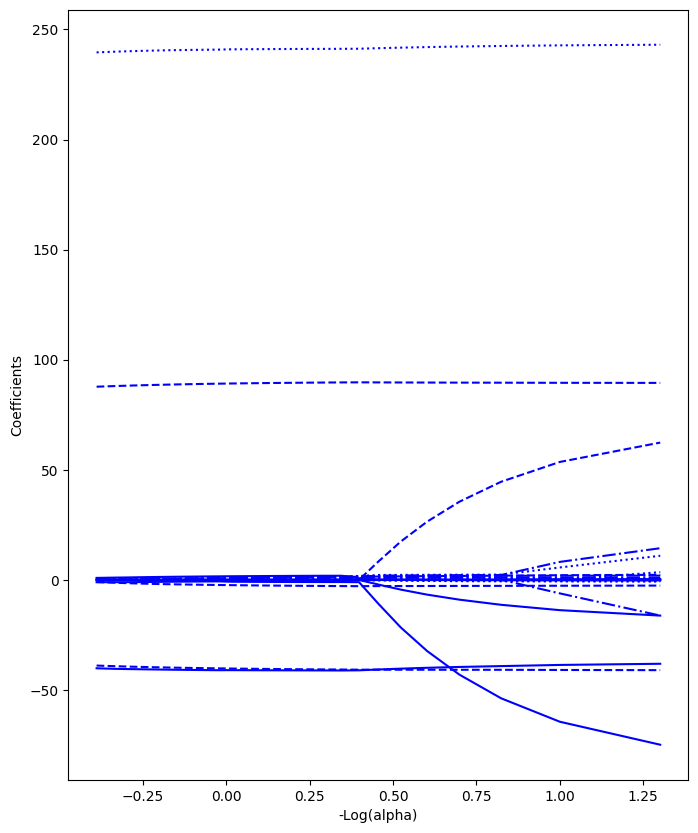

In [53]:
from itertools import cycle
# print(type(YC_train))
# print(np.shape(XC_train),np.shape(YC_train))
from sklearn.linear_model import lasso_path
alphas_lasso, coefs_lasso, _ = lasso_path(XC_train,YC_train, alphas=np.array(range(1,50,1))/20.,)

plt.figure()
ax = plt.gca()

styles = cycle(['-', '--', '-.', ':'])

neg_log_alphas_lasso = -np.log10(alphas_lasso)
# print(np.shape(neg_log_alphas_lasso ))
# print(np.shape(coefs_lasso))
# print(np.shape(alphas_lasso))
for coef_l, s in zip(coefs_lasso, styles):
    
   
    l1 = plt.plot(neg_log_alphas_lasso, coef_l, linestyle=s,c='b')
plt.xlabel('-Log(alpha)')
plt.ylabel('Coefficients')
plt.show()

## 2. kNN et SVR

## 2.1 kNN

Voici les hyperparamètres possibles à optimiser dans le cas d'une kNN régression. 

| Paramètre       | Type / Valeurs possibles                    | Description                                                              |
| --------------- | ------------------------------------------- | ------------------------------------------------------------------------ |
| `n_neighbors`   | `int` (ex: `1` à `30`)                      | Nombre de voisins à prendre en compte                                    |
| `weights`       | `['uniform', 'distance']`                   | Poids accordés aux voisins (égaux ou proportionnels à la distance)       |
| `algorithm`     | `['auto', 'ball_tree', 'kd_tree', 'brute']` | Algorithme pour la recherche des plus proches voisins                    |
| `leaf_size`     | `int` (ex: `10` à `100`)                    | Paramètre utilisé dans `kd_tree` ou `ball_tree`                          |
| `p`             | `1` ou `2`                                  | Paramètre de la distance de Minkowski : `1 = manhattan`, `2 = euclidean` |
| `metric`        | `['minkowski', 'euclidean', 'manhattan']`   | Type de distance utilisée                                                |
| `metric_params` | `dict`                                      | Paramètres supplémentaires pour la métrique (rarement utilisé)           |
| `n_jobs`        | `-1` ou `int`                               | Nombre de cœurs utilisés (utile en GridSearch)                           |


In [54]:
from sklearn.neighbors import KNeighborsRegressor

# Optimisation de k (nombre de voisins)
param_grid = {
    'n_neighbors': [3, 5, 10,12,15,18],
    'weights': ['uniform', 'distance'],
    'p': [1, 2],
    'leaf_size': [10,20, 30, 40]
}
knn_reg = GridSearchCV(KNeighborsRegressor(), param_grid, cv=5, n_jobs=-1)
knnOpt = knn_reg.fit(XC_train, YC_train)

# Meilleur paramètre
print("Meilleur score (cross-val MSE) = %f, Meilleur paramètre = %s" % (1 - knnOpt.best_score_, knnOpt.best_params_))

Meilleur score (cross-val MSE) = 0.334864, Meilleur paramètre = {'leaf_size': 10, 'n_neighbors': 15, 'p': 1, 'weights': 'distance'}


In [55]:
# Prédictions sur l’échantillon test
prev_kNN = knnOpt.predict(XC_test)

# Calcul du MSE sur test
mse_kNN = mean_squared_error(YC_test, prev_kNN)
print("MSE sur l'échantillon test : %.2f" % mse_kNN) #gros MSE ? 
print("R2=",r2_score(YC_test,prev_kNN)) 
mse_score_model["kNN"]= mse_kNN
R2_model["kNN"]=r2_score(YC_test,prev_kNN)


MSE sur l'échantillon test : 22624.89
R2= 0.7342540609291496


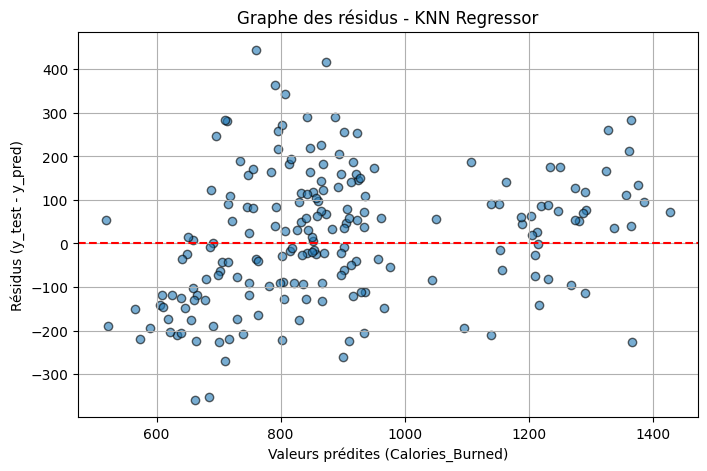

In [56]:
# Tracé des résidus
residus_kNN = YC_test - prev_kNN
plt.figure(figsize=(8, 5))
plt.scatter(prev_kNN, residus_kNN, alpha=0.6, edgecolors='k')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Valeurs prédites (Calories_Burned)')
plt.ylabel('Résidus (y_test - y_pred)')
plt.title('Graphe des résidus - KNN Regressor')
plt.grid(True)
plt.show()

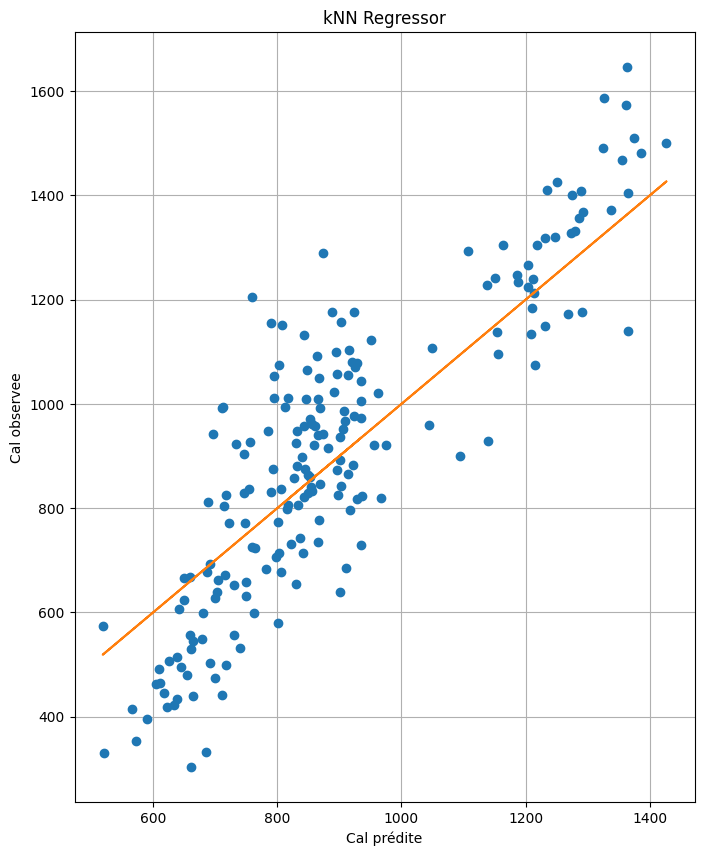

In [57]:
#Valeurs prédites contre les valeurs observées 
plt.plot(prev_kNN,YC_test,"o")
plt.plot(prev_kNN,prev_kNN)
plt.xlabel(u"Cal prédite")
plt.ylabel("Cal observee")
plt.title("kNN Regressor")
plt.grid(True)
plt.show()


On va tester avec notre sélection de variables. 

In [58]:
# Optimisation de k (nombre de voisins)
knnOpt_sel = knn_reg.fit(XC_train_sel, YC_train)

# Meilleur paramètre
print("Meilleur score (cross-val MSE) = %f, Meilleur paramètre = %s" % (1 - knnOpt_sel.best_score_, knnOpt_sel.best_params_))

Meilleur score (cross-val MSE) = 0.183424, Meilleur paramètre = {'leaf_size': 10, 'n_neighbors': 5, 'p': 1, 'weights': 'distance'}


In [59]:
# Prédictions sur l’échantillon test
prev_kNN_sel = knnOpt.predict(XC_test_sel)

# Calcul du MSE sur test
mse_kNN_sel = mean_squared_error(YC_test, prev_kNN_sel)
print("MSE sur l'échantillon test : %.2f" % mse_kNN_sel) 
# MSE plus basse avec sélection de variable mais tjr haut par rapport aux autres méthodes 
print("R2=",r2_score(YC_test,prev_kNN_sel)) 

mse_score_model_sel["kNN"]= mse_kNN_sel
R2_model_sel["kNN"]=r2_score(YC_test,prev_kNN_sel)


MSE sur l'échantillon test : 10960.32
R2= 0.8712630312079874


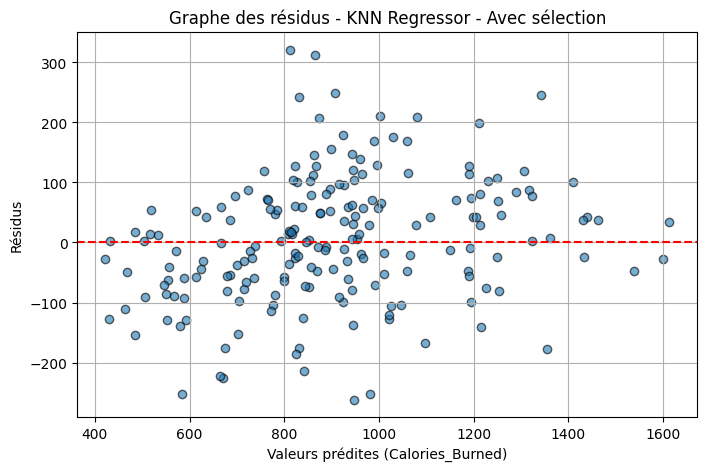

In [60]:
# Tracé des résidus
residus_kNN_sel = YC_test - prev_kNN_sel
plt.figure(figsize=(8, 5))
plt.scatter(prev_kNN_sel, residus_kNN_sel, alpha=0.6, edgecolors='k')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Valeurs prédites (Calories_Burned)')
plt.ylabel('Résidus')
plt.title('Graphe des résidus - KNN Regressor - Avec sélection')
plt.grid(True)
plt.show()

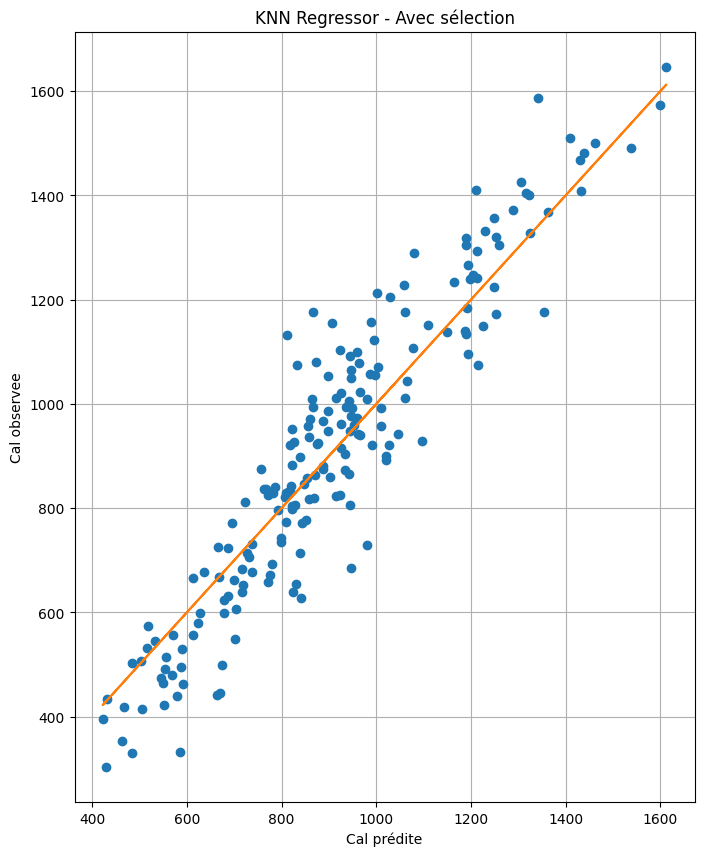

In [61]:
#Valeurs prédites contre les valeurs observées 
plt.plot(prev_kNN_sel,YC_test,"o")
plt.plot(prev_kNN_sel,prev_kNN_sel)
plt.xlabel(u"Cal prédite")
plt.ylabel("Cal observee")
plt.title("KNN Regressor - Avec sélection")
plt.grid(True)
plt.show()


## 2.2 SVR

Hyperparamètres possibles à optimiser : 
| Paramètre   | Valeurs typiques à tester                | Rôle                                                                                                                    |
| ----------- | ---------------------------------------- | ----------------------------------------------------------------------------------------------------------------------- |
| `C`         | `[0.01, 0.1, 1, 10, 100]`                | Contrôle la **pénalité** sur les erreurs : un **C élevé** => moins de tolérance à l’erreur, risque de surapprentissage. |
| `epsilon`   | `[0.001, 0.01, 0.1, 1]`                  | Définie la **zone autour de la prédiction** dans laquelle aucune pénalité n'est appliquée (le “tube ε-insensitive”).    |
| `kernel`    | `["linear", "poly", "rbf", "sigmoid"]`   | Noyau utilisé pour la projection des données. `rbf` est souvent un bon choix par défaut.                                |
| `gamma`     | `["scale", "auto", 0.001, 0.01, 0.1, 1]` | Utilisé avec les noyaux non linéaires. Contrôle l’influence d’un seul point d’entraînement.                             |
| `degree`    | `[2, 3, 4, 5]` *(si kernel='poly')*      | Degré du polynôme pour le noyau polynomial.                                                                             |
| `shrinking` | `[True, False]`                          | Active ou non l’heuristique de **réduction du vecteur de support**.                                                     |
| `tol`       | `[1e-3, 1e-4]`                           | Critère de **tolérance** d’arrêt.                                                                                       |


Le paramètre C contrôle le compromis entre biais et variance :

    Petit C → le modèle accepte plus d'erreur à l'intérieur du tube ε, ce qui donne une solution plus lisse (plus de biais, moins de variance).

    Grand C → le modèle pénalise fortement les erreurs, cherchant à prédire le plus proche possible des vraies valeurs (moins de biais, mais plus de variance).

In [62]:
from sklearn.svm import SVR
#Au cas où, important pour cette méthode
scaler = StandardScaler()
XC_train = scaler.fit_transform(XC_train)
XC_test = scaler.transform(XC_test)
#optimisation des autres paramètres 
param_grid = { 
    "C": [0.1, 1, 10, 100],
    "epsilon": [0.01, 0.1, 1,2],
    "kernel": ["rbf"],
    "gamma": ["scale", "auto"]
}

svr = GridSearchCV(SVR(), param_grid, cv=5, n_jobs=-1)
svrOpt = svr.fit(XC_train, YC_train)
print("Sans SV, Meilleur score = %f, Meilleur paramètre = %s" % (1. - svrOpt.best_score_, svrOpt.best_params_))


Sans SV, Meilleur score = 0.050240, Meilleur paramètre = {'C': 100, 'epsilon': 1, 'gamma': 'auto', 'kernel': 'rbf'}


In [63]:
# erreur de régression sur le test
1-svrOpt.score(XC_test,YC_test)

0.027926146407164176

In [64]:
# Prédictions sur le jeu de test
pred_svr = svrOpt.predict(XC_test)
# Calcul des résidus
residus_svr = YC_test - pred_svr
# Calcul du MSE
mse_svr = mean_squared_error(YC_test, pred_svr)
print("Sans SV, MSE sur l'échantillon test (SVR) : %.2f" % mse_svr)
print("Sans SV, R2=",r2_score(YC_test,pred_svr)) 

mse_score_model["SVR"]=mse_svr
R2_model["SVR"]=r2_score(YC_test,pred_svr)



Sans SV, MSE sur l'échantillon test (SVR) : 2377.56
Sans SV, R2= 0.9720738535928358


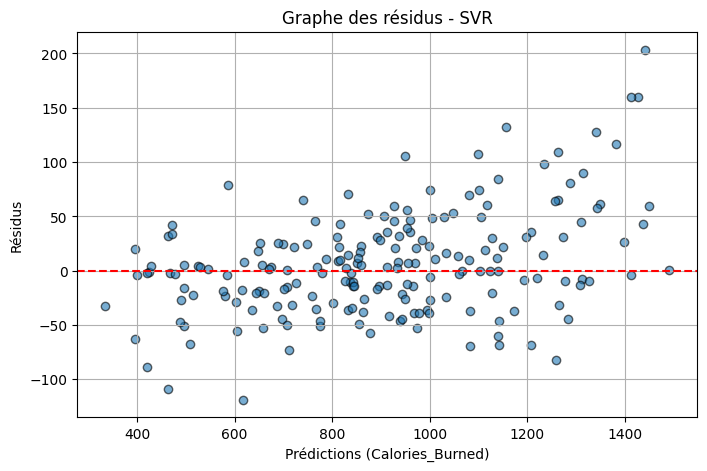

In [65]:
# Tracé des résidus
plt.figure(figsize=(8, 5))
plt.scatter(pred_svr, residus_svr, alpha=0.6, edgecolors='k')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Prédictions (Calories_Burned)')
plt.ylabel('Résidus')
plt.title('Graphe des résidus - SVR')
plt.grid(True)
plt.show()

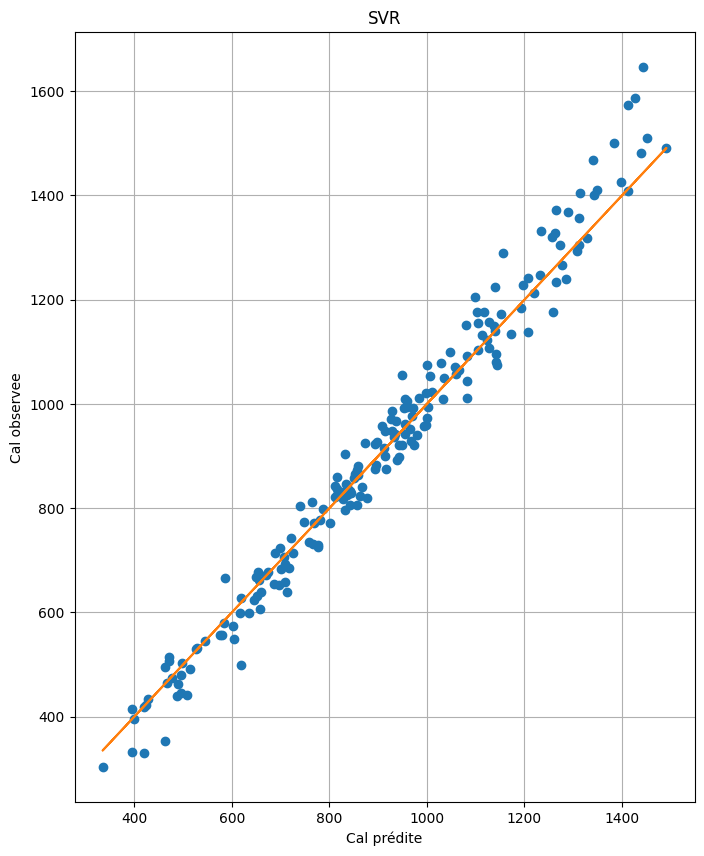

In [66]:
plt.plot(pred_svr,YC_test,"o")
plt.plot(pred_svr,pred_svr)
plt.xlabel(u"Cal prédite")
plt.ylabel("Cal observee")
plt.title("SVR")
plt.grid(True)
plt.show()

### SVR avec sélection de variables

In [67]:
svrOpt_sel=svr.fit(XC_train_sel,YC_train)
print("Avec SV, Meilleur score = %f, Meilleur paramètre = %s" % (1. - svrOpt_sel.best_score_, svrOpt_sel.best_params_))

Avec SV, Meilleur score = 0.037810, Meilleur paramètre = {'C': 100, 'epsilon': 0.01, 'gamma': 'auto', 'kernel': 'rbf'}


In [68]:
# erreur de régression sur le test
1-svrOpt_sel.score(XC_test_sel,YC_test)

0.022413349919811476

In [69]:
# Prédictions sur le jeu de test
pred_svr_sel = svrOpt_sel.predict(XC_test_sel)

# Calcul des résidus
residus_svr_sel = YC_test - pred_svr_sel

# Calcul du MSE
mse_svr_sel = mean_squared_error(YC_test, pred_svr_sel)
print("Avec SV, MSE sur l'échantillon test (SVR) : %.2f" % mse_svr_sel)
print("Avec SV, R2=",r2_score(YC_test,pred_svr_sel)) 

mse_score_model_sel["SVR"]=mse_svr_sel
R2_model_sel["SVR"]=r2_score(YC_test,pred_svr_sel)

Avec SV, MSE sur l'échantillon test (SVR) : 1908.21
Avec SV, R2= 0.9775866500801885


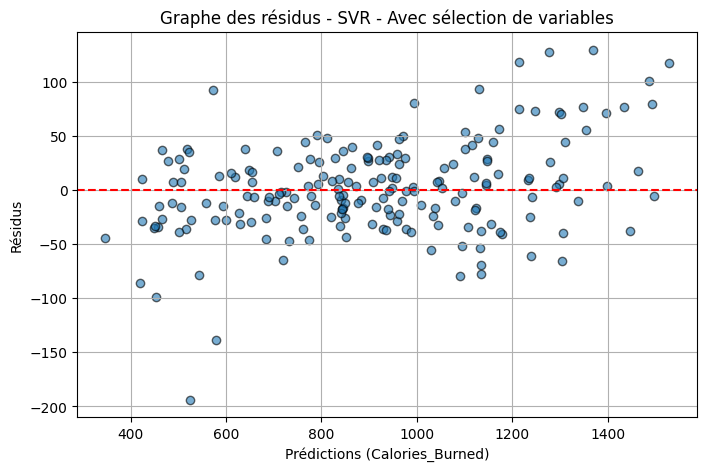

In [70]:
# Tracé des résidus
plt.figure(figsize=(8, 5))
plt.scatter(pred_svr_sel, residus_svr_sel, alpha=0.6, edgecolors='k')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Prédictions (Calories_Burned)')
plt.ylabel('Résidus')
plt.title('Graphe des résidus - SVR - Avec sélection de variables')
plt.grid(True)
plt.show()

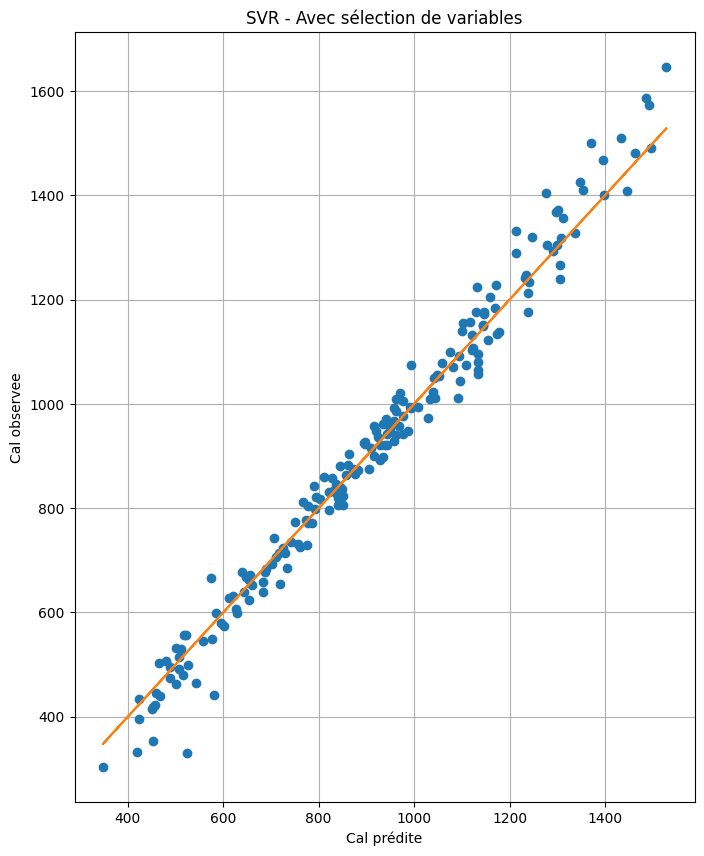

In [71]:
plt.plot(pred_svr_sel,YC_test,"o")
plt.plot(pred_svr_sel,pred_svr_sel)
plt.xlabel(u"Cal prédite")
plt.ylabel("Cal observee")
plt.title("SVR - Avec sélection de variables")
plt.grid(True)
plt.show()

# Arbre de régression 

In [72]:
from sklearn.tree import DecisionTreeRegressor

# Optimisation de la profondeur de l'arbre
param = [{"max_depth": list(range(2, 10))}]
tree = GridSearchCV(DecisionTreeRegressor(), param, cv=10, n_jobs=-1)
treeOpt = tree.fit(XC_train, YC_train)

# Affichage du meilleur paramètre
print("Meilleur score = %f, Meilleur paramètre = %s" % (1. - treeOpt.best_score_, treeOpt.best_params_))
# Prédictions sur le jeu de test
y_pred_tree = treeOpt.predict(XC_test)

# MSE
mse_tree = mean_squared_error(YC_test, y_pred_tree)
print("MSE sur l'échantillon test (arbre de régression) : %.2f" % mse_tree)
print("R2=",r2_score(YC_test,y_pred_tree)) 


Meilleur score = 0.079483, Meilleur paramètre = {'max_depth': 8}
MSE sur l'échantillon test (arbre de régression) : 5015.97
R2= 0.9410837612052281


MSE sur l'échantillon test : 5015.9690
R2= 0.9410837612052281


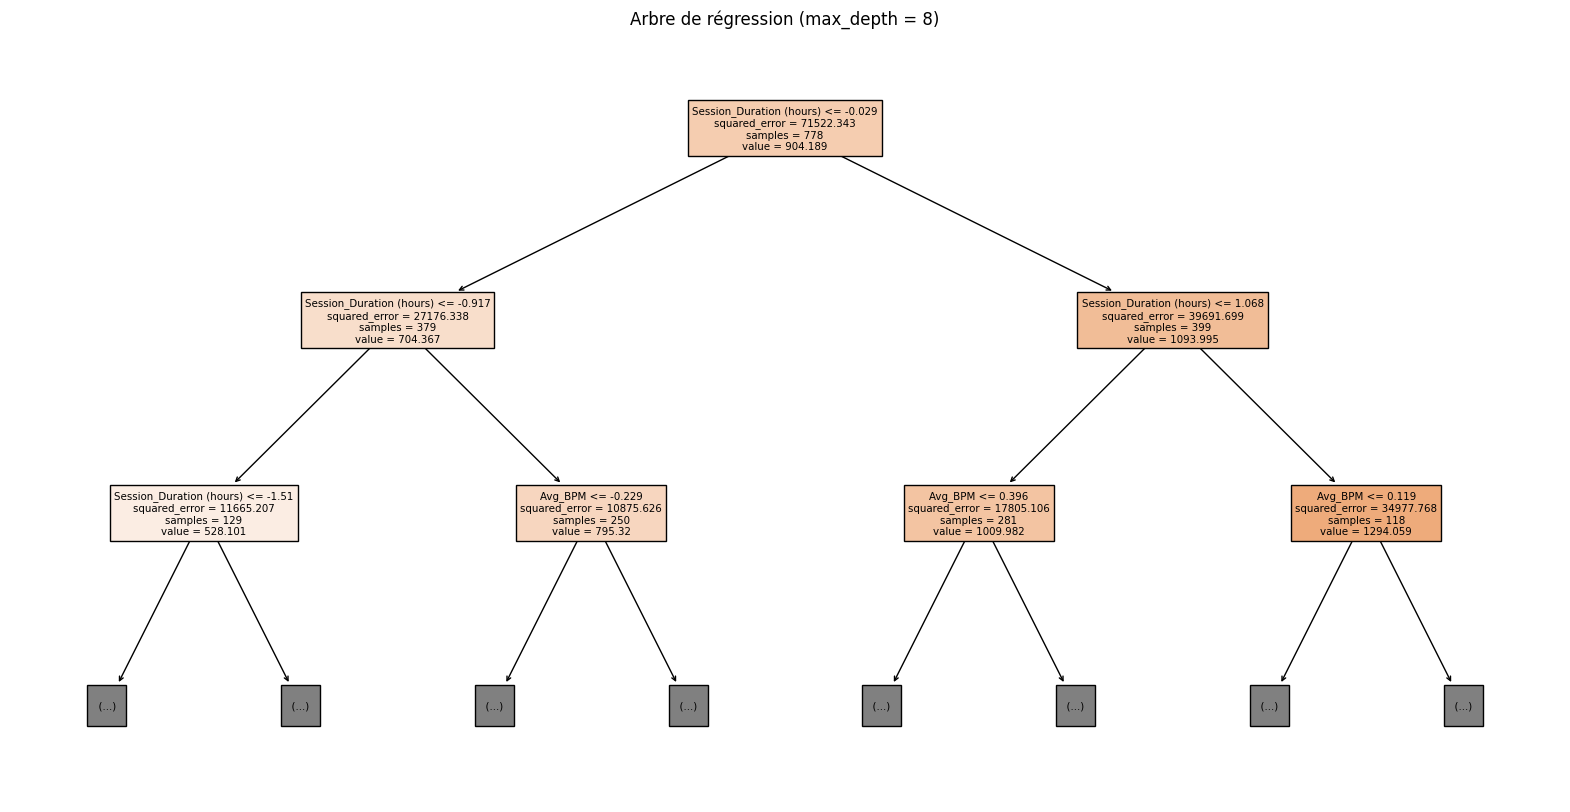

In [73]:
from sklearn.tree import DecisionTreeRegressor, plot_tree
# Ré-entraînement de l'arbre avec la profondeur optimale trouvée
treeG = DecisionTreeRegressor(max_depth=treeOpt.best_params_['max_depth'])
treeG.fit(XC_train, YC_train)

# Calcul du MSE
mse_tree = mean_squared_error(YC_test, y_pred_tree)
print(f"MSE sur l'échantillon test : {mse_tree:.4f}")
print("R2=",r2_score(YC_test,y_pred_tree))

mse_score_model["Regressor Tree"]=mean_squared_error(YC_test, y_pred_tree)
R2_model_sel["Regressor Tree"]=r2_score(YC_test,y_pred_tree)

 
# Tracé de l'arbre
plt.figure(figsize=(20, 10))  # Ajuste la taille pour la lisibilité
plot_tree(treeG, feature_names=dfC.columns.tolist(), filled=True, max_depth=2)
plt.title("Arbre de régression (max_depth = %d)" % treeOpt.best_params_['max_depth'])
plt.show()


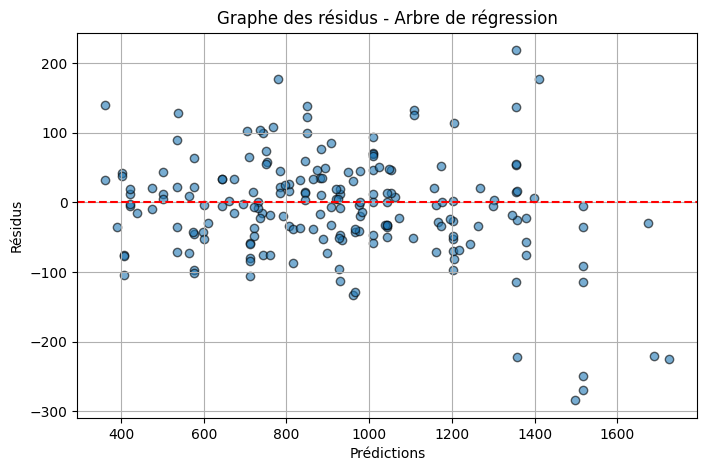

In [74]:

# Prédictions sur l'échantillon test
y_pred_tree = treeG.predict(XC_test)

# Calcul des résidus
residus_tree  = YC_test - y_pred_tree

# Tracé des résidus
plt.figure(figsize=(8,5))
plt.scatter(y_pred_tree, residus_tree , alpha=0.6, edgecolors='k')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Prédictions')
plt.ylabel('Résidus')
plt.title('Graphe des résidus - Arbre de régression')
plt.grid(True)
plt.show()

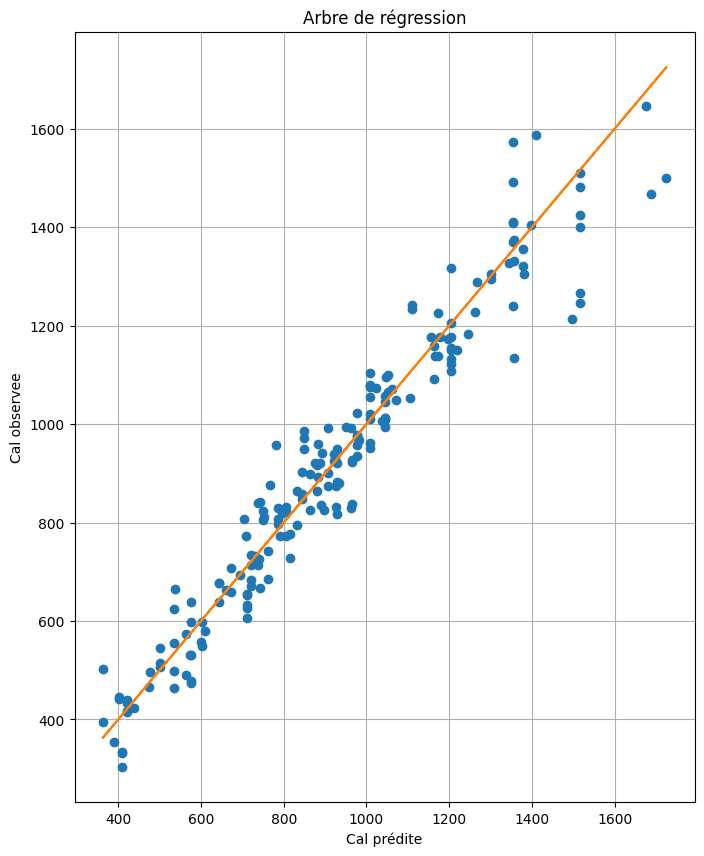

In [75]:
plt.plot(y_pred_tree,YC_test,"o")
plt.plot(y_pred_tree,y_pred_tree)
plt.xlabel(u"Cal prédite")
plt.ylabel("Cal observee")
plt.title("Arbre de régression")
plt.grid(True)
plt.show()

### Avec sélection de variables

In [76]:
#Entrainement avec sélection
treeOpt_sel = tree.fit(XC_train_sel, YC_train)

# Affichage du meilleur paramètre
print("Meilleur score = %f, Meilleur paramètre = %s" % (1. - treeOpt_sel.best_score_, treeOpt_sel.best_params_))
# Prédictions sur le jeu de test
y_pred_tree_sel = treeOpt.predict(XC_test_sel)

# MSE
mse_tree_sel = mean_squared_error(YC_test, y_pred_tree_sel)
print("MSE sur l'échantillon test (arbre de régression) : %.2f" % mse_tree_sel)
print("R2=",r2_score(YC_test,y_pred_tree_sel)) 

mse_score_model_sel['Regressor Tree']=mse_tree_sel
R2_model_sel["Regressor Tree"]=r2_score(YC_test,y_pred_tree_sel)

Meilleur score = 0.064989, Meilleur paramètre = {'max_depth': 9}
MSE sur l'échantillon test (arbre de régression) : 4317.15
R2= 0.9492918451766644


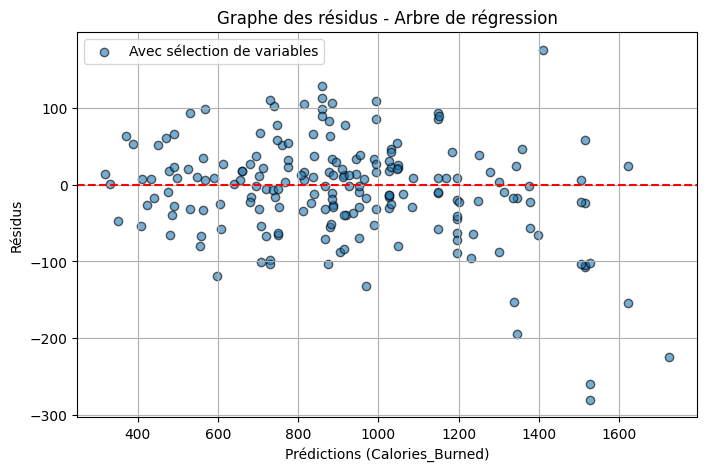

In [77]:
# Tracé des résidus
# Calcul des résidus
residus_tree_sel = YC_test - y_pred_tree_sel
plt.figure(figsize=(8, 5))
plt.scatter(y_pred_tree_sel, residus_tree_sel, alpha=0.6, edgecolors='k',label="Avec sélection de variables")
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Prédictions (Calories_Burned)')
plt.legend()
plt.ylabel('Résidus')
plt.title('Graphe des résidus - Arbre de régression')
plt.grid(True)
plt.show()

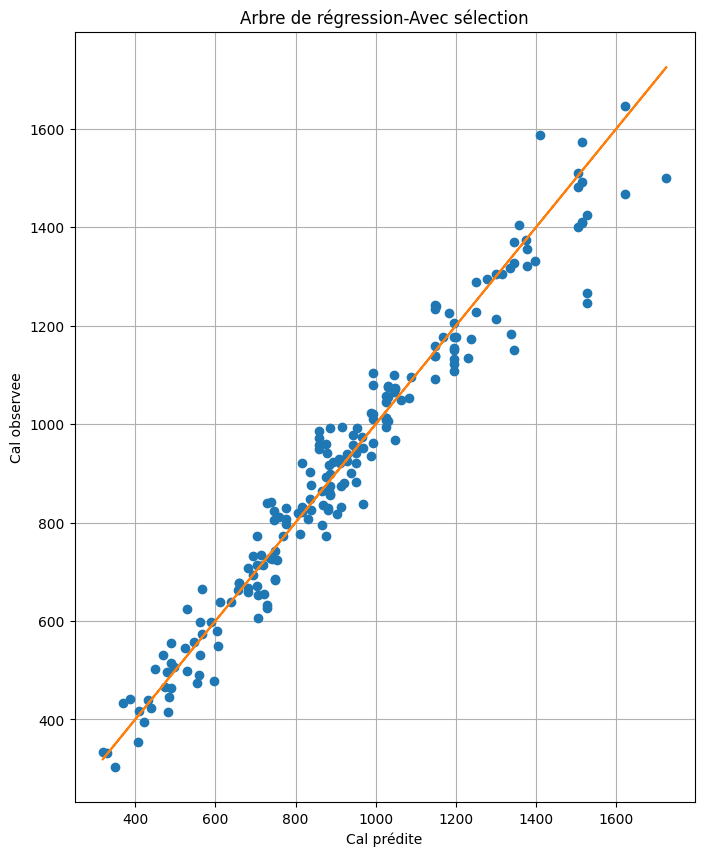

In [78]:
plt.plot(y_pred_tree_sel,YC_test,"o")
plt.plot(y_pred_tree_sel,y_pred_tree_sel)
plt.xlabel(u"Cal prédite")
plt.ylabel("Cal observee")
plt.title("Arbre de régression-Avec sélection")
plt.grid(True)
plt.show()

# 4 Forêt aléatoire 

Meilleur score = 0.032262, Meilleur paramètre = {'max_features': 21}
MSE sur échantillon test = 1790.4186
R2= 0.9789702186048947


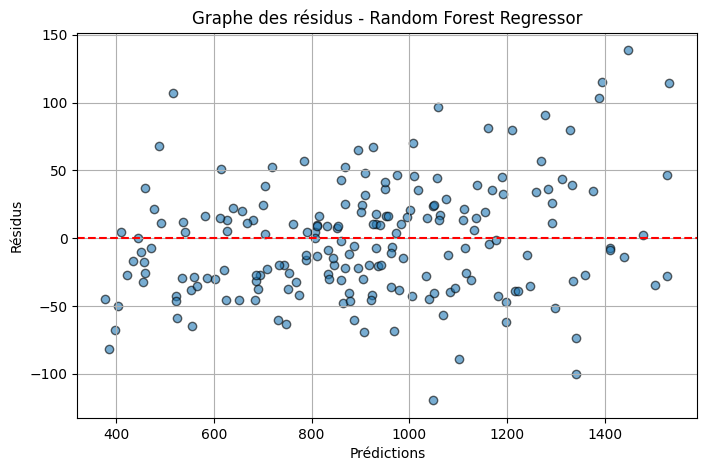

In [89]:
from sklearn.ensemble import RandomForestRegressor

param = [{"max_features": list(range(5, 22))}]
rf = GridSearchCV(RandomForestRegressor(n_estimators=100, random_state=42,oob_score=True),
                  param, cv=5, n_jobs=-1)
rfOpt = rf.fit(XC_train, YC_train)

print("Meilleur score = %f, Meilleur paramètre = %s" % (1. - rfOpt.best_score_, rfOpt.best_params_))


# Prédiction sur l'échantillon test
pred_Rtree = rfOpt.predict(XC_test)

# Calcul du MSE sur l'échantillon test
mse = mean_squared_error(YC_test, pred_Rtree)
print(f"MSE sur échantillon test = {mse:.4f}")
print("R2=",r2_score(YC_test,pred_Rtree)) 
mse_score_model["Random forest"]=mean_squared_error(YC_test, pred_Rtree)
R2_model["Random forest"]=r2_score(YC_test,pred_Rtree)
# Tracé des résidus
residus_Rtree = YC_test - pred_Rtree
plt.figure(figsize=(8,5))
plt.scatter(pred_Rtree, residus_Rtree, alpha=0.6, edgecolors='k')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Prédictions')
plt.ylabel('Résidus')
plt.title('Graphe des résidus - Random Forest Regressor')
plt.grid(True)
plt.show()

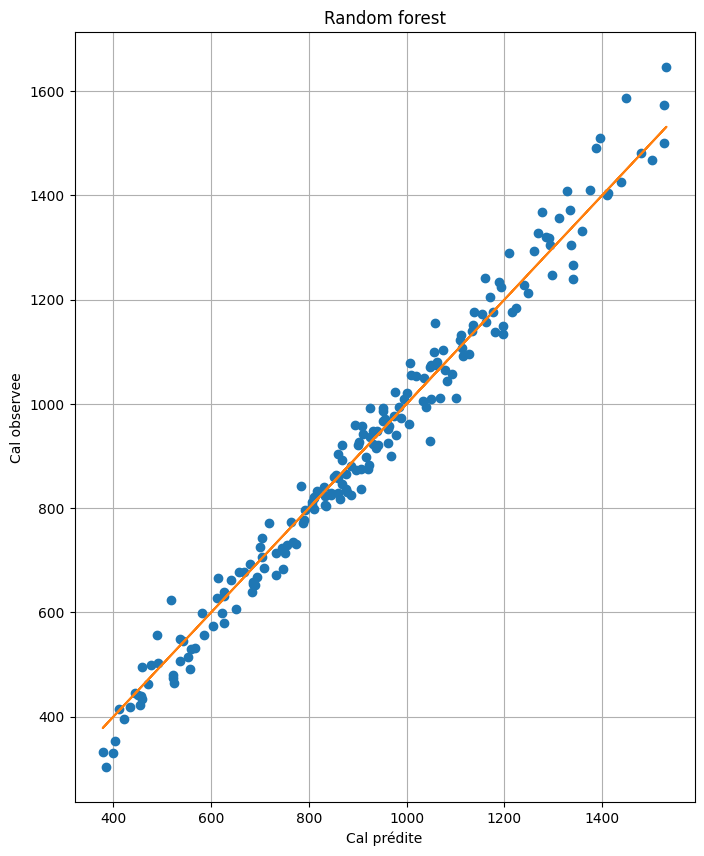

In [90]:
plt.plot(pred_Rtree,YC_test,"o")
plt.plot(pred_Rtree,pred_Rtree)
plt.xlabel(u"Cal prédite")
plt.ylabel("Cal observee")
plt.title("Random forest")
plt.grid(True)
plt.show()

In [91]:
# erreur de prévision sur le test
1-rfOpt.score(XC_test,YC_test)

0.02102978139510525

In [92]:
para_opt=rfOpt.best_params_["max_features"]
rf = RandomForestRegressor(n_estimators=100, max_features=para_opt, random_state=42)
rfFit = rf.fit(XC_train, YC_train)

# Importance décroissante des variables
importances = rfFit.feature_importances_
indices = np.argsort(importances)[::-1] # on tri par ordre décroissant les indices associés

# on affiche l'importance par variables
i=1
for f in range(XC_train.shape[1]):
    print(i,df_norm.columns[indices[f]], importances[indices[f]])
    i=i+1

1 Session_Duration (hours) 0.6998019646506353
2 Avg_BPM 0.11286346662975015
3 Experience_Level_3 0.06241598639287128
4 Fat_Percentage 0.02856252128561866
5 BCFat_Percentage 0.027721544555895157
6 Age 0.019775238998299697
7 Experience_Level_1 0.005440719434751597
8 Gender_Female 0.005095175120321524
9 Height (m) 0.004897457491295976
10 Gender_Male 0.0047407242336679
11 Experience_Level_2 0.004705306795284395
12 sWeight (kg) 0.004061674803020651
13 Water_Intake (liters) 0.004010795264514069
14 Weight (kg) 0.003130680173462238
15 Max_BPM 0.002717649869483877
16 Resting_BPM 0.0025704222539340246
17 BMI 0.0023538901015961863
18 sBMI 0.002321557263383851
19 Workout_Type_Strength 0.0005551821048130518
20 Workout_Type_Cardio 0.0004301922268445167
21 Workout_Type_HIIT 0.0003890914732420834
22 Workout_Type_Yoga 0.0003820583977801971
23 Workout_Frequency (days/week)_3 0.0003398147995769657
24 Workout_Frequency (days/week)_4 0.0003359051213373516
25 Workout_Frequency (days/week)_2 0.00019287210529

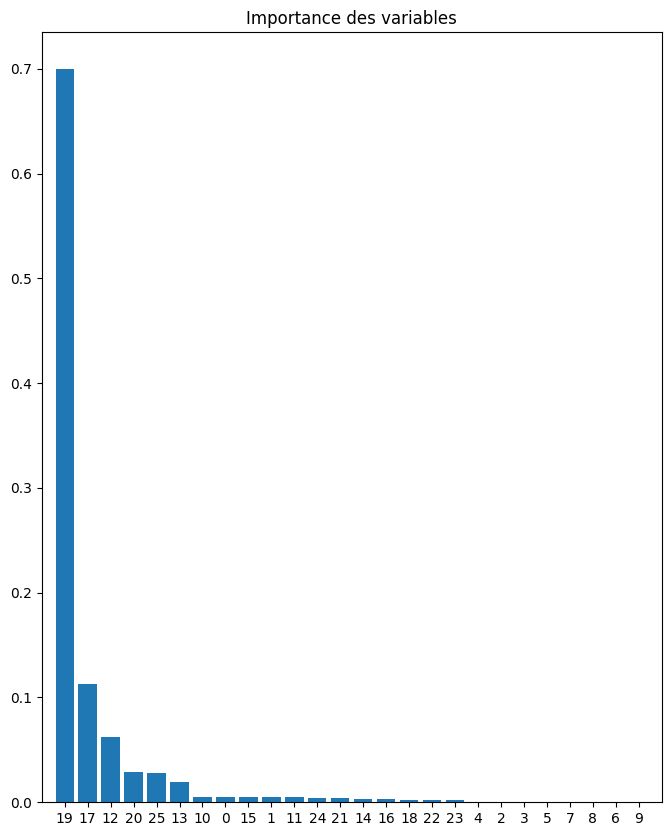

In [93]:
# Graphe des importances
plt.figure()
plt.title("Importance des variables")
plt.bar(range(XC_train.shape[1]), importances[indices])
plt.xticks(range(XC_train.shape[1]), indices)
plt.xlim([-1, XC_train.shape[1]])
plt.show()

## Boosting : XGBOOST

| Hyperparamètre          | Description                                                 | Valeurs courantes à tester      |
| ----------------------- | ----------------------------------------------------------- | ------------------------------- |
| `n_estimators`          | Nombre d’arbres dans la forêt                               | 50, 100, 200, 500               |
| `max_depth`             | Profondeur maximale des arbres                              | 3, 4, 5, 6, 8                   |
| `learning_rate` (eta)   | Taux d’apprentissage (contrôle la taille des pas)           | 0.01, 0.05, 0.1, 0.2            |
| `subsample`             | Fraction d’échantillons utilisés pour chaque arbre          | 0.6, 0.8, 1.0                   |
| `colsample_bytree`      | Fraction des features utilisés par arbre                    | 0.5, 0.7, 1.0                   |
| `gamma`                 | Gain minimal requis pour faire une nouvelle division        | 0, 0.1, 0.2, 1                  |
| `min_child_weight`      | Poids minimal requis dans un nœud                           | 1, 3, 5                         |
| `reg_alpha`             | Coefficient de régularisation L1                            | 0, 0.01, 0.1                    |
| `reg_lambda`            | Coefficient de régularisation L2                            | 1, 1.5, 2                       |
| `scale_pos_weight`      | Pour traiter déséquilibre des classes (rare en régression)  | 1 (souvent pas utilisé)         |
| `objective`             | Fonction objectif (ex: 'reg\:squarederror' pour régression) | Fixé en général pour régression |
| `seed` / `random_state` | Fixe la graine aléatoire pour reproductibilité              | Valeur fixe, ex: 42             |


Meilleur score =  439.7899351279055
Meilleur paramètre =  {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300}
MSE sur test = 340.8314
R2 sur test = 0.9960


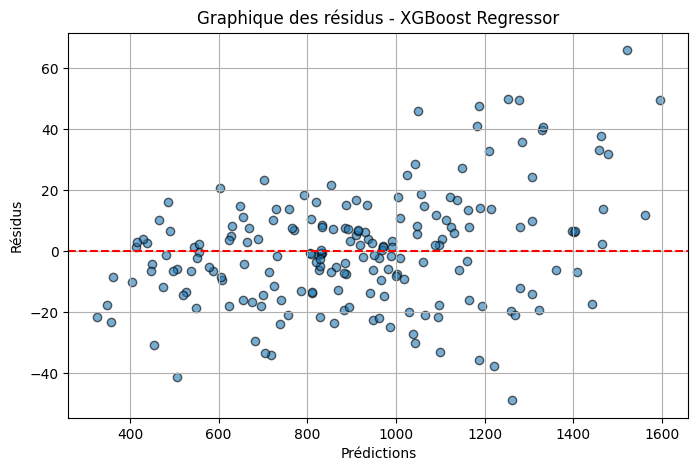

In [94]:
import xgboost as xgb

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Création du modèle XGBoost Regressor
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Grille d'hyperparamètres à tester
param_grid = {
    "max_depth": [3, 5, 7, 9],        # profondeur des arbres
    "learning_rate": [0.01, 0.1, 0.2], # taux d'apprentissage
    "n_estimators": [100, 200, 300]    # nombre d'arbres
}

# Recherche par validation croisée
grid_search = GridSearchCV(xgb_model, param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')
grid_search.fit(XC_train, YC_train)

# Meilleurs paramètres et score
print("Meilleur score = ", -grid_search.best_score_)
print("Meilleur paramètre = ", grid_search.best_params_)

# Meilleur modèle
best_model = grid_search.best_estimator_

# Prédictions sur le jeu test
y_pred_Boost = best_model.predict(XC_test)

# Calcul MSE et R2
mse_boost = mean_squared_error(YC_test, y_pred_Boost)
r2_boost = r2_score(YC_test, y_pred_Boost)
print(f"MSE sur test = {mse_boost:.4f}")
print(f"R2 sur test = {r2_boost:.4f}")

mse_score_model["XGBOOST"]=mse_boost
R2_model["XGBOOST"]=r2_boost

# Graphe des résidus
residus = YC_test - y_pred_Boost
plt.figure(figsize=(8,5))
plt.scatter(y_pred_Boost, residus, alpha=0.6, edgecolors='k')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Prédictions')
plt.ylabel('Résidus')
plt.title('Graphique des résidus - XGBoost Regressor')
plt.grid(True)
plt.show()

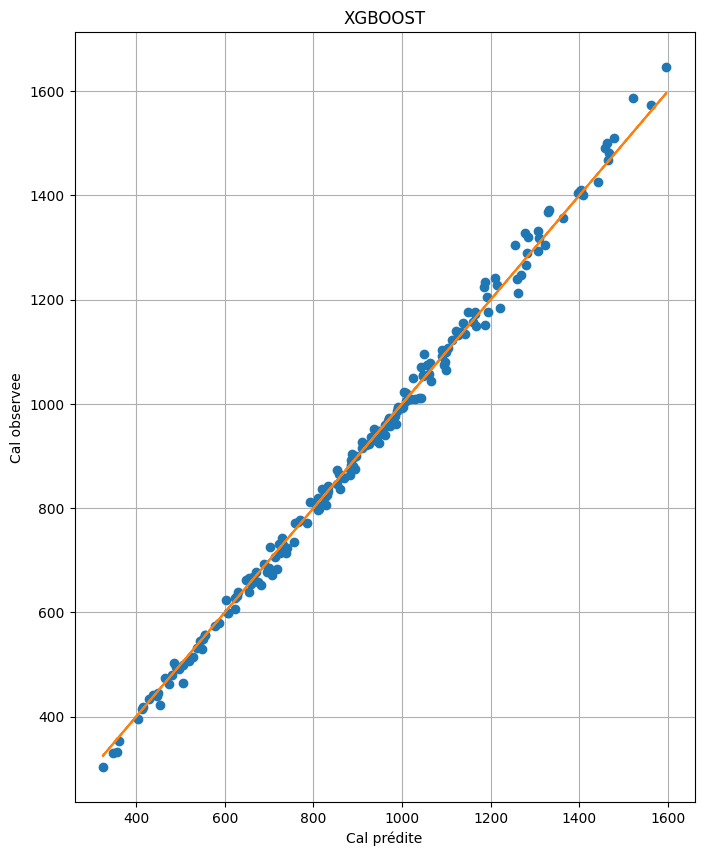

In [95]:
plt.plot(y_pred_Boost,YC_test,"o")
plt.plot(y_pred_Boost,y_pred_Boost)
plt.xlabel(u"Cal prédite")
plt.ylabel("Cal observee")
plt.title("XGBOOST")
plt.grid(True)
plt.show()

### Conclusion : (Random Forest + boosting)
On obtient de très bons résultats avec une méthode Random Forest doublé d'un boosting. Le fait d'optimiser d'une grille de paramètres au lieu de juste la profondeur permet d'obtenir des meilleurs résultats. 

Cette méthode est pour le moment celle qui obtient les meilleurs résultats. On va encore tester la prédiction par réseaux de neuronnes en utilisant *sklearn* puis avec architectures plus profondes avec *tensorflow*.

# 5 Réseaux de Neuronnes

| Paramètre            | Type / Valeurs possibles                        | Rôle                                                             |
| -------------------- | ----------------------------------------------- | ---------------------------------------------------------------- |
| `hidden_layer_sizes` | `[(50,), (100,), (50,50), (100,50), (100,100)]` | Architecture du réseau (nombres de neurones par couche cachée)   |
| `activation`         | `["identity", "logistic", "tanh", "relu"]`      | Fonction d'activation dans les couches cachées                   |
| `solver`             | `["lbfgs", "sgd", "adam"]`                      | Algorithme d’optimisation                                        |
| `alpha`              | `[0.0001, 0.001, 0.01, 0.1, 1]`                 | Terme de régularisation L2                                       |
| `batch_size`         | `["auto", 16, 32, 64, 128]`                     | Taille des mini-lots pour SGD ou adam                            |
| `learning_rate`      | `["constant", "invscaling", "adaptive"]`        | Stratégie d’adaptation du taux d’apprentissage                   |
| `learning_rate_init` | `[0.001, 0.01, 0.1]`                            | Taux d’apprentissage initial                                     |
| `max_iter`           | `[200, 300, 500, 1000]`                         | Nombre maximal d’itérations                                      |
| `early_stopping`     | `[True, False]`                                 | Active un arrêt automatique si la validation ne s'améliore plus  |
| `tol`                | `[1e-4, 1e-3]`                                  | Tolérance pour l’arrêt de l’optimisation                         |
| `momentum`           | `[0.9, 0.95, 0.99]` (si `solver='sgd'`)         | Moment utilisé lors de l’optimisation par SGD                    |
| `n_iter_no_change`   | `[5, 10, 20]`                                   | Nombre d’itérations sans amélioration pour `early_stopping=True` |


In [87]:
from sklearn.neural_network import MLPRegressor

Fitting 5 folds for each of 120 candidates, totalling 600 fits
Meilleur score = 0.981235
Meilleur paramètre = {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (50, 25), 'learning_rate_init': 0.01, 'solver': 'adam'}
MSE sur test = 1790.4186
R2= 0.9829059233472008


c:\Users\edgar\anaconda3\envs\tf-scikit\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


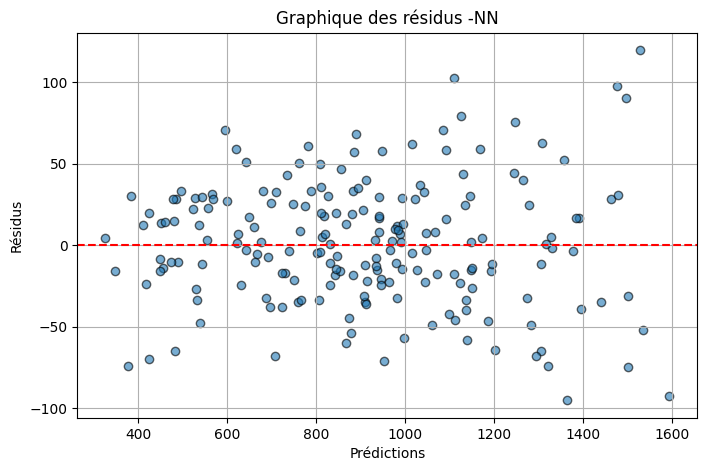

In [88]:
#Système de paramètres pour l'optimisation
param_grid = {
    "hidden_layer_sizes": [(50,), (100,), (100, 50), (50, 25),(150,)], #opti (100,50)
    "activation": ["relu", "tanh"],
    "solver": ["adam", "lbfgs"],
    "alpha": [0.0001, 0.001, 0.01],
    "learning_rate_init": [0.001, 0.01],
}

mlp = MLPRegressor(max_iter=300, random_state=42) 

grid_search = GridSearchCV(mlp, param_grid, cv=5, n_jobs=-1, verbose=2)#validation croisée pour trouver les paramètres opti
grid_search.fit(XC_train, YC_train)

print("Meilleur score = %f" % (grid_search.best_score_)) # score moyen obtenu en validation croisée 
print("Meilleur paramètre =", grid_search.best_params_)

# Évaluation sur test
best_model = grid_search.best_estimator_
pred_NN = best_model.predict(XC_test)
mse_NN = mean_squared_error(YC_test, pred_NN)
print(f"MSE sur test = {mse:.4f}")
print("R2=",r2_score(YC_test,pred_NN))   # R2 sur l'échantillon test 

mse_score_model["NN"]=mse_NN
R2_model["NN"]=r2_score(YC_test,pred_NN)


residuals = YC_test - pred_NN
plt.figure(figsize=(8,5))
plt.scatter(pred_NN, residuals, alpha=0.6, edgecolors='k')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Prédictions')
plt.ylabel('Résidus')
plt.title('Graphique des résidus -NN')
plt.grid(True)
plt.show()

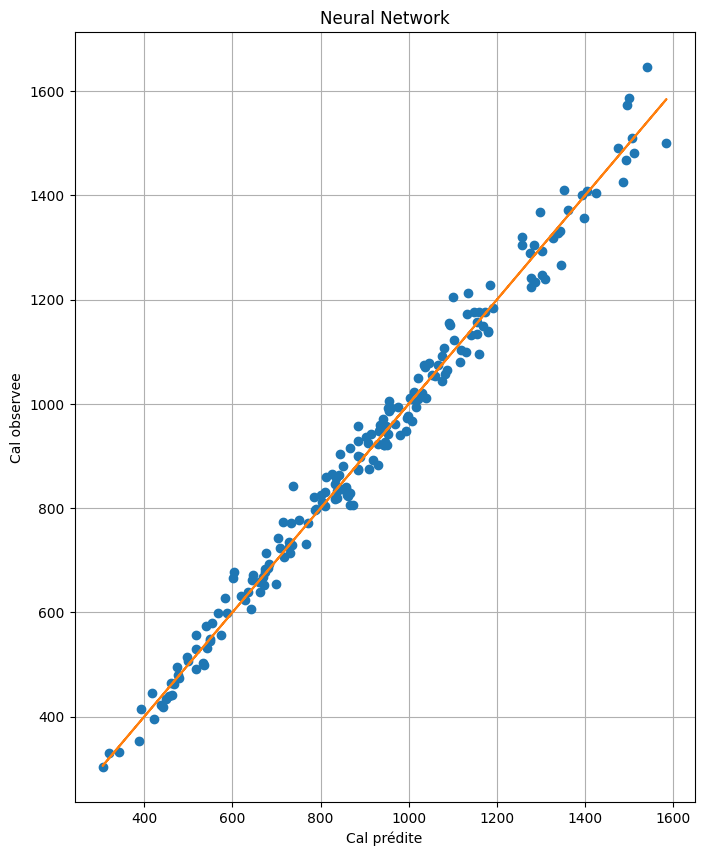

In [ ]:
plt.plot(pred_NN,YC_test,"o")
plt.plot(pred_NN,pred_NN)
plt.xlabel(u"Cal prédite")
plt.ylabel("Cal observee")
plt.title("Neural Network")
plt.grid(True)
plt.show()

### Avec sélection de variables


Fitting 5 folds for each of 120 candidates, totalling 600 fits


c:\Users\edgar\anaconda3\envs\tf-scikit\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Meilleur score = 0.985571
Meilleur paramètre = {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (150,), 'learning_rate_init': 0.01, 'solver': 'adam'}
MSE sur test = 928.5140
R2= 0.9890939219249164


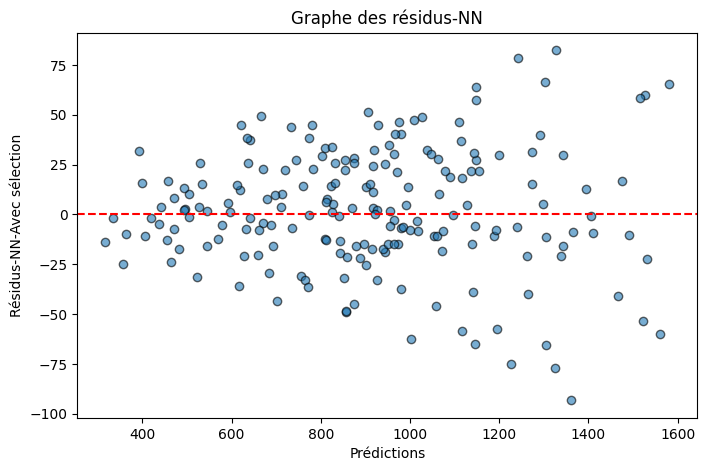

In [ ]:
#Système de paramètres pour l'optimisation
mlp = MLPRegressor(max_iter=500, random_state=42) 

grid_search_sel = GridSearchCV(mlp, param_grid, cv=5, n_jobs=-1, verbose=2)#validation croisée pour trouver les paramètres opti
grid_search_sel.fit(XC_train_sel, YC_train)

print("Meilleur score = %f" % (grid_search_sel.best_score_)) # score moyen obtenu en validation croisée 
print("Meilleur paramètre =", grid_search_sel.best_params_)

# Évaluation sur test
best_model_sel = grid_search_sel.best_estimator_
pred_NN_sel = best_model_sel.predict(XC_test_sel)
mse = mean_squared_error(YC_test, pred_NN_sel )
print(f"MSE sur test = {mse:.4f}")
print("R2=",r2_score(YC_test,pred_NN_sel ))   # R2 sur l'échantillon test 

residuals = YC_test - pred_NN_sel 
plt.figure(figsize=(8,5))
plt.scatter(pred_NN_sel , residuals, alpha=0.6, edgecolors='k')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Prédictions")
plt.ylabel("Résidus-NN-Avec sélection")
plt.title("Graphe des résidus-NN")
plt.show()



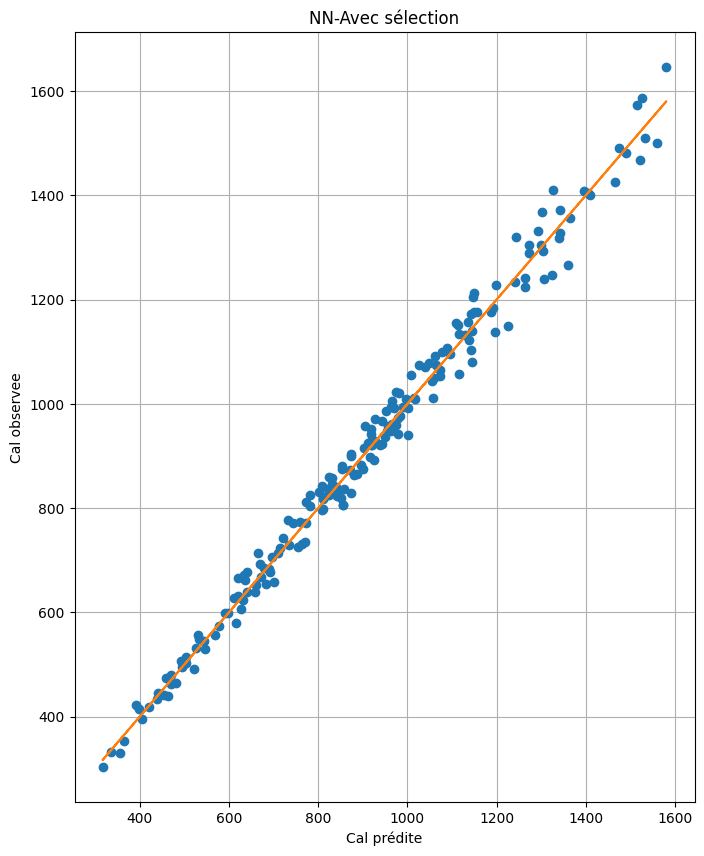

In [ ]:
plt.plot(pred_NN_sel,YC_test,"o")
plt.plot(pred_NN_sel,pred_NN_sel)
plt.xlabel(u"Cal prédite")
plt.ylabel("Cal observee")
plt.title("NN-Avec sélection")
plt.grid(True)
plt.show()

# 6. Deep-learning et réseaux profonds 
On va maintenant mettre en place un réseau profond avec la bibliothèque *tensorflow*. On rappelle les hyperparamètres qui sont optimissables pour ce type de modèles : 

| Hyperparamètre          | Description                                            | Valeurs possibles courantes                                                 |
| ----------------------- | ------------------------------------------------------ | --------------------------------------------------------------------------- |
| **n\_hidden**           | Nombre de couches cachées                              | 1, 2, 3, 4, 5                                                               |
| **n\_neurons**          | Nombre de neurones par couche cachée                   | 16, 32, 64, 128, 256                                                        |
| **activation**          | Fonction d’activation dans les couches cachées         | `'relu'`, `'tanh'`, `'sigmoid'`, `'elu'`                                    |
| **optimizer**           | Algorithme d’optimisation                              | `'adam'`, `'sgd'`, `'rmsprop'`, `'adagrad'`, `'adamax'`                     |
| **learning\_rate**      | Taux d’apprentissage                                   | 0.001, 0.01, 0.1, 0.0001                                                    |
| **batch\_size**         | Nombre d’exemples par batch lors de l’entraînement     | 16, 32, 64, 128                                                             |
| **epochs**              | Nombre d’itérations complètes sur le dataset           | 10, 20, 50, 100                                                             |
| **dropout\_rate**       | Fraction de neurones "éteints" lors du dropout         | 0.0 (pas de dropout), 0.1, 0.2, 0.3                                         |
| **weight\_initializer** | Méthode d'initialisation des poids                     | `'glorot_uniform'`, `'he_normal'`, `'random_normal'`                        |
| **loss\_function**      | Fonction de perte                                      | `'mse'` (régression), `'binary_crossentropy'`, `'categorical_crossentropy'` |
| **early\_stopping**     | Arrêt anticipé pour éviter surapprentissage (callback) | patience=5, monitor='val\_loss'                                             |
| **momentum**            | Pour optimizers SGD (optionnel)                        | 0.0, 0.9                                                                    |
| **regularization**      | Pénalisation L1, L2 pour éviter le surapprentissage    | lambda: 0.001, 0.01                                                         |


In [96]:
from scikeras.wrappers import KerasRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import GridSearchCV

# Définir la fonction de création du réseau
def build_model(n_hidden=1, n_neurons=32, learning_rate=0.01):
    model = Sequential()
    model.add(Dense(n_neurons, input_shape=(XC_train.shape[1],), activation='relu')) #couche d'entrée
    for _ in range(n_hidden - 1): #nombre des couches cachés
        model.add(Dense(n_neurons, activation='relu')) #couche dense avec fonction activation relu 
    model.add(Dense(1))  # Régression : couche de sortie (1 sortie)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse') # fonction perte MSE
    return model

# Utilisation de scikeras
model = KerasRegressor(
    model=build_model,
    n_hidden=1,
    n_neurons=32,
    learning_rate=0.01,
    epochs=100,
    batch_size=32,
    verbose=0
)

# Grille des hyperparamètres
param_grid = {
    'n_hidden': [1, 2],
    'n_neurons': [16, 32, 64],
    'learning_rate': [0.001, 0.01],
    'batch_size': [32, 64],
    'epochs': [50, 100]
}

# Grid search 
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=1)
grid_result = grid.fit(XC_train, YC_train)


Meilleur score (val. MSE) = 0.9806
Meilleurs paramètres : {'batch_size': 32, 'epochs': 100, 'learning_rate': 0.01, 'n_hidden': 1, 'n_neurons': 64}
MSE sur test = 1109.1358
R2= 0.9869723857013902


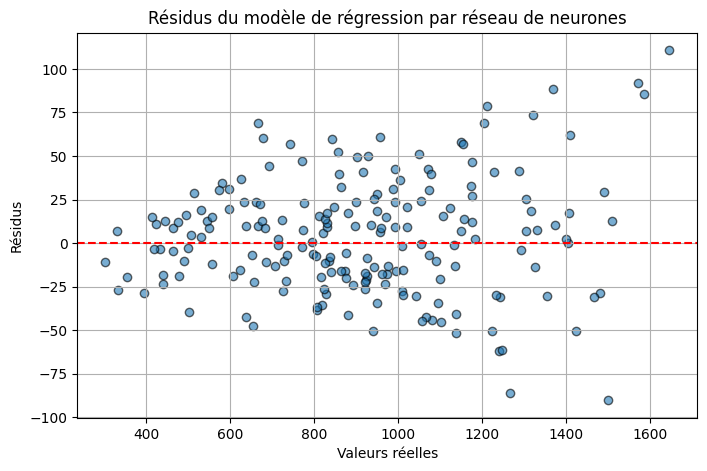

In [ ]:
# Résultat optimal
print("Meilleur score (val. MSE) = %.4f" % abs(grid_result.best_score_))  # convention MSE négative en sortie de la cross-validation
print("Meilleurs paramètres :", grid_result.best_params_)

# Prédiction avec le meilleur modèle
best_model = grid_result.best_estimator_
pred_DNN = best_model.predict(XC_test)

# Calcul des résidus et du MSE
residuals_DNN = YC_test - pred_DNN
mse_DNN = mean_squared_error(YC_test, pred_DNN)
print("MSE sur test = %.4f" % mse_DNN)
print("R2=",r2_score(YC_test,pred_DNN))   # R2 sur l'échantillon test 

mse_score_model["DNN"]=mse_DNN
R2_model["DNN"]=r2_score(YC_test,pred_DNN)

# Tracé des résidus
plt.figure(figsize=(8, 5))
plt.scatter(YC_test, residuals_DNN, alpha=0.6, edgecolors='k')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Valeurs réelles")
plt.ylabel("Résidus")
plt.title("Résidus - réseau de neurones profond")
plt.grid(True)
plt.show()

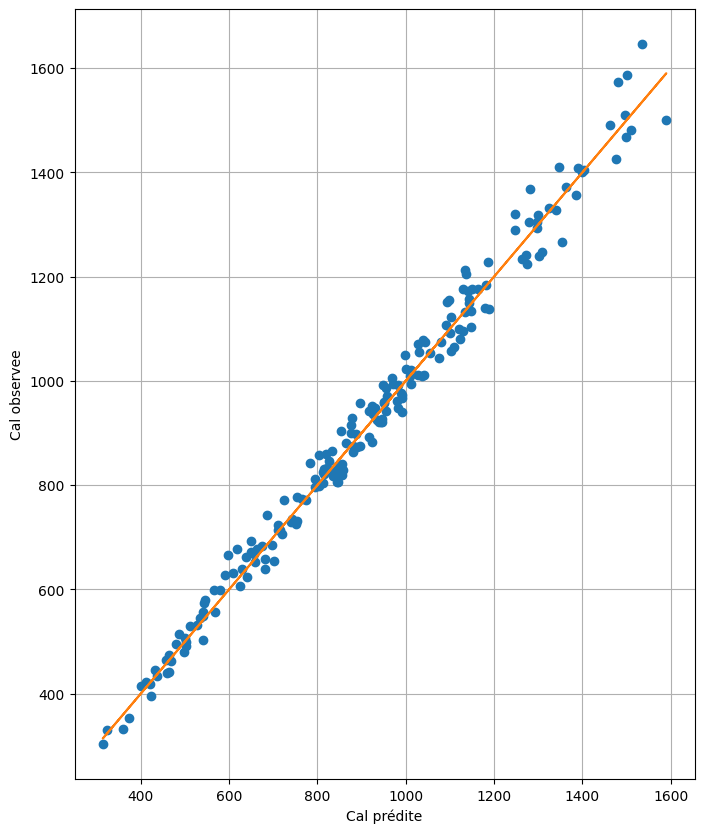

In [ ]:
plt.plot(pred_DNN,YC_test,"o")
plt.plot(pred_DNN,pred_DNN)
plt.xlabel(u"Cal prédite")
plt.ylabel("Cal observee")
plt.title("Réseau neurones profond")
plt.grid(True)
plt.show()